## Predicting Hotel Booking Cancellation with Machine Learning

Group Members: Jingwei Chen, Ju-Hsuan Hsieh, Junze Li, Yuening Zhan, Yunbei Wang

### Outlines

- 1.Data Fetching and Cleaning
- 2.Exploratory Data Analysis
- 3.Feature Engineering
- 4.Supervised machine learning

### 1. Data Fetching and Cleaning

In [1]:
import io
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix,average_precision_score

In [2]:
booking_data = pd.read_csv('hotel_bookings.csv')

In [3]:
booking_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
booking_data.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

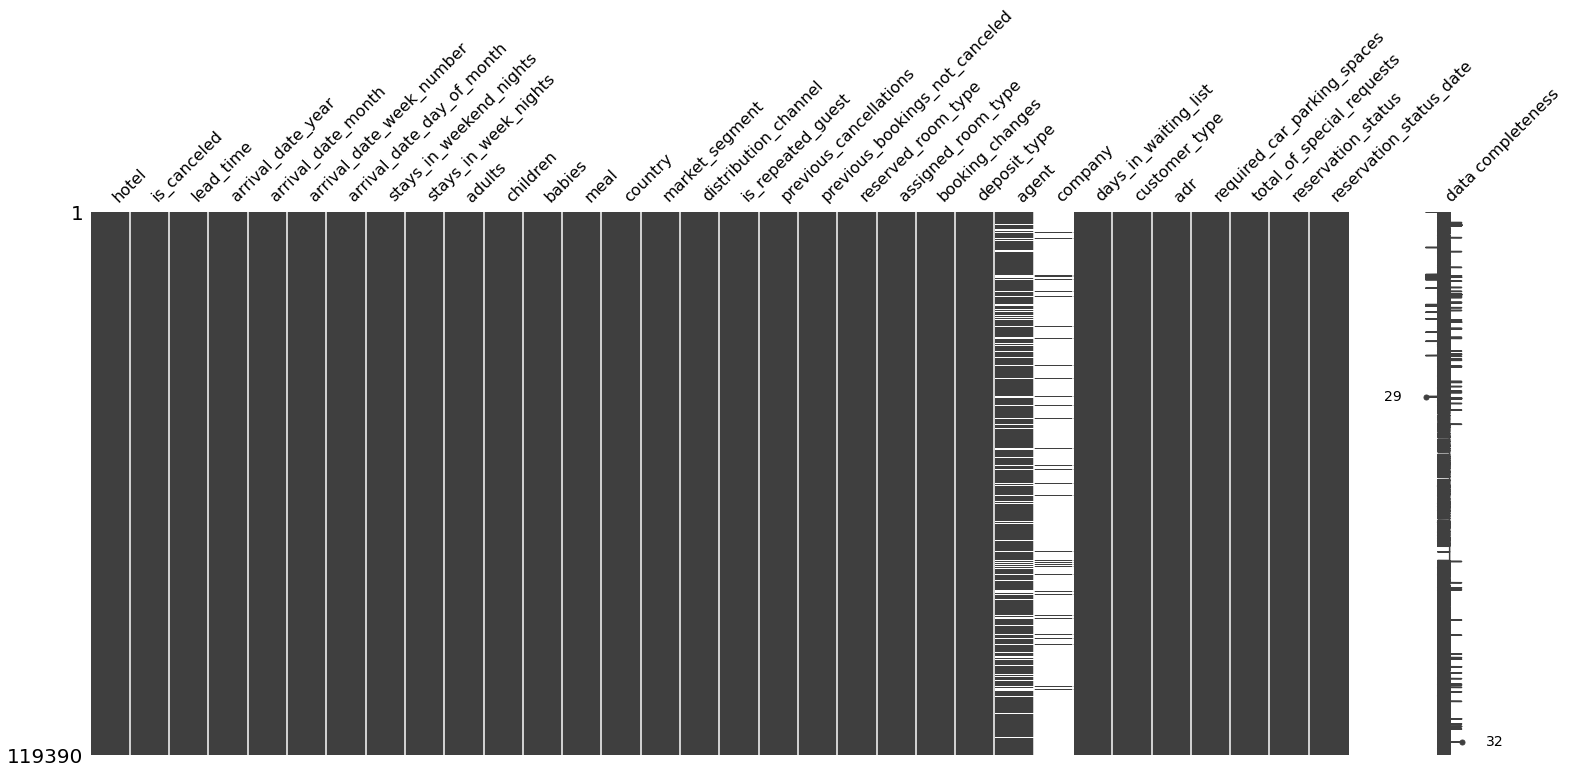

In [5]:
msno.matrix(booking_data, labels=True)
plt.show()

In [6]:
booking_data.isnull().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                           True
babies                            False
meal                              False
country                            True
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                              True
company                            True


We notice that there are some missing values in **children**, **country**, **agent** and **company**. For **children** and **country**, there are only 4 and 488 missing values respectively, which is a very small proportion. So we drop the booking records which contain missing values in **children** and **country**.

In [7]:
children_del_list = booking_data[(booking_data['children'].isnull())].index.tolist()
country_del_list = booking_data[(booking_data['country'].isnull())].index.tolist()

In [8]:
booking_data_cleaned = booking_data.drop(set(children_del_list + country_del_list))

In [9]:
print('We delete {} booking records and there are {} records remaining.'.format(len(booking_data)-len(booking_data_cleaned), len(booking_data_cleaned)))

We delete 492 booking records and there are 118898 records remaining.


For the remaining two attributes:

In [10]:
print('There are {} missing values in agent and {} in company.'.format(len(booking_data_cleaned[booking_data_cleaned['agent'].isnull() == True]), len(booking_data_cleaned[booking_data_cleaned['company'].isnull() == True])))

There are 16004 missing values in agent and 112275 in company.


These two attributes mean the agent/company IDs if the booking is made by agent/company, and the values of the remaining records are NULL. We can also notice that there are large proportion of booking records which are not made by agent/company, so we can not delete them directly. 
- For the EDA part, we can analyze the impact of agent/company. 
- For the feature engineering part, we can remove these two attributes for the further prediction based on machine learning.

In [11]:
print('There are {} booking records after data cleaning.'.format(len(booking_data_cleaned)))

There are 118898 booking records after data cleaning.


---

### 2. Exploratory Data Analysis

**The proportion of cancelled bookings**

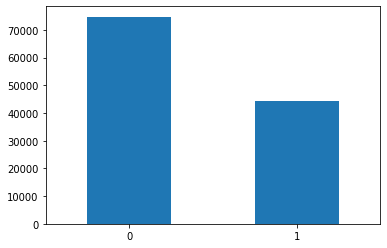

In [12]:
booking_data_cleaned['is_canceled'].value_counts().plot(kind='bar', rot=0)
plt.show()

In [13]:
ratio = booking_data_cleaned['is_canceled'].value_counts() / sum(booking_data['is_canceled'].value_counts())
print(ratio) # A bit of imbalance

0    0.626057
1    0.369822
Name: is_canceled, dtype: float64


**The relationship between country and cancellation status**

In [14]:
# Find the country code
if not os.path.exists('country_code.csv'):
    print('Load "country_code.csv" from Internet')
    try:
        import requests
    except:
        !conda install requests -y
    url = 'https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv'
    response = requests.get(url)
    file = io.StringIO(response.content.decode('utf-8'))
    country_code = pd.read_csv(file)
    country_code.to_csv('country_code.csv')
else:
    print('Load "country_code.csv" from local disk')
    country_code = pd.read_csv('country_code.csv')
print(pd.unique(country_code.Continent_Name))
print(pd.unique(country_code.Continent_Code))

Load "country_code.csv" from Internet
['Asia' 'Europe' 'Antarctica' 'Africa' 'Oceania' 'North America'
 'South America']
['AS' 'EU' 'AN' 'AF' 'OC' nan 'SA']


In [15]:
country_code.loc[country_code.Continent_Name == 'North America', 'Continent_Code'] = 'NA'
print(pd.unique(country_code.Continent_Name))
print(pd.unique(country_code.Continent_Code))

['Asia' 'Europe' 'Antarctica' 'Africa' 'Oceania' 'North America'
 'South America']
['AS' 'EU' 'AN' 'AF' 'OC' 'NA' 'SA']


In [16]:
def country_to_continent(code):
    if len(code) == 3:
        return country_code[country_code.Three_Letter_Country_Code == i].Continent_Code
    elif len(code) == 2:
        return country_code[country_code.Two_Letter_Country_Code == i].Continent_Code
    else:
        raise ValueError('Wrong country code length = {}'.format(len(code)))

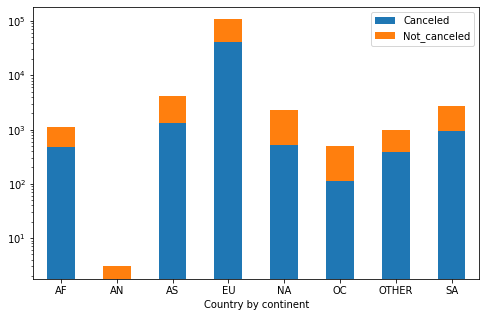

In [17]:
country = {}
for i in pd.unique(booking_data_cleaned.country):
    continent = list(country_to_continent(i))
    if len(continent) == 1:
        country[i] = continent[0]
    else:
        country[i] = 'OTHER'
booking_data_cleaned.country = booking_data_cleaned.country.apply(lambda x: country[x])
df_temp = booking_data_cleaned.loc[:, ['is_canceled', 'country']]
df_temp['not_canceled'] = -df_temp.is_canceled + 1
df_temp.columns = ['Canceled', 'Country by continent', 'Not_canceled']
df_temp = df_temp.pivot_table(values=['Canceled', 'Not_canceled'], index='Country by continent', aggfunc='sum')
df_temp.plot.bar(stacked=True, figsize=[8, 5], rot=0)
plt.yscale('log')

In [18]:
sum(booking_data_cleaned.country == 'EU') / len(booking_data_cleaned)

0.901529041699608

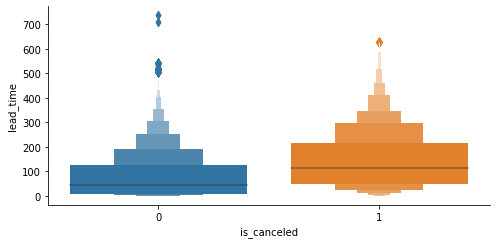

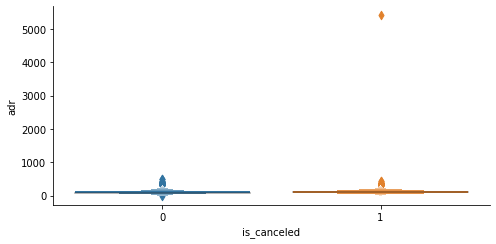

In [19]:
continuous_features = ["lead_time","adr"]
for feature in continuous_features:
    sns.catplot(y=feature,x="is_canceled",data=booking_data_cleaned,kind="boxen",height=3.5, aspect=2)
    plt.show()

In [20]:
booking_data_cleaned.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,102894.000000,6623.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,0.371352,104.311435,2016.157656,27.166555,15.800880,0.928897,2.502145,1.858391,0.104207,0.007948,0.032011,0.087142,0.131634,0.221181,86.545532,189.624792,2.330754,102.003243,0.061885,0.571683
std,0.483168,106.903309,0.707459,13.589971,8.780324,0.996216,1.900168,0.578576,0.399172,0.097380,0.176029,0.845869,1.484672,0.652785,110.714259,132.124298,17.630452,50.485862,0.244172,0.792678
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [21]:
booking_data_cleaned[booking_data_cleaned["adr"] > 5000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
48515,City Hotel,1,35,2016,March,13,25,0,1,2,...,Non Refund,12.0,NaN,0,Transient,5400.0,0,0,Canceled,2016-02-19


In [22]:
booking_data_cleaned_adr = booking_data_cleaned[booking_data_cleaned["adr"] < 5000]

In [23]:
booking_data_cleaned_adr.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,102893.000000,6623.000000,118897.000000,118897.000000,118897.000000,118897.000000
mean,0.371347,104.312018,2016.157657,27.166674,15.800802,0.928905,2.502157,1.858390,0.104208,0.007948,0.032011,0.087143,0.131635,0.221175,86.546257,189.624792,2.330774,101.958683,0.061885,0.571688
std,0.483167,106.903570,0.707462,13.589966,8.780321,0.996217,1.900171,0.578578,0.399174,0.097381,0.176030,0.845872,1.484678,0.652784,110.714553,132.124298,17.630525,48.091199,0.244173,0.792680
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,510.000000,8.000000,5.000000


#### There are two types of hotel, we want to observe the data of each type separately

In [24]:
Resort_Hotel_data = booking_data_cleaned_adr[booking_data_cleaned_adr["hotel"] == "Resort Hotel"]
City_Hotel_data = booking_data_cleaned_adr[booking_data_cleaned_adr["hotel"] == "City Hotel"]

Resort_ratio = len(Resort_Hotel_data)  / (len(City_Hotel_data) +len(Resort_Hotel_data))
print("Resort_ratio = {}".format(Resort_ratio))
City_ratio = len(City_Hotel_data)  / (len(City_Hotel_data) +len(Resort_Hotel_data))
print("City_ratio = {}".format(City_ratio))

Resort_ratio = 0.33302774670513136
City_ratio = 0.6669722532948686


In the whole dataset, we have 0.33 of Resort hotel data and 0.66 City hotel data.

In [25]:
Resort_canceled_ratio = Resort_Hotel_data['is_canceled'].value_counts()  / sum(Resort_Hotel_data ['is_canceled'].value_counts())
print(Resort_canceled_ratio) 

0    0.72025
1    0.27975
Name: is_canceled, dtype: float64


In the Resort hotel data, there are around 72% bookings not canceled and 28% bookings canceled.

In [26]:
City_canceled_ratio = City_Hotel_data['is_canceled'].value_counts()  / sum(City_Hotel_data ['is_canceled'].value_counts())
print(City_canceled_ratio) 

0    0.582918
1    0.417082
Name: is_canceled, dtype: float64


In the City hotel data, there are around 58% bookings not canceled and 41% bookings canceled.

In [27]:
Canceled_data = booking_data_cleaned_adr[booking_data_cleaned_adr['is_canceled']==1]
City_Hotel_canceled = City_Hotel_data[City_Hotel_data['is_canceled']==1]
Resort_Hotel_canceled = Resort_Hotel_data[Resort_Hotel_data['is_canceled']==1]
print("In all the canceled data, there are {:.2f}% is from City hotel".format(100*len(City_Hotel_canceled)/len(Canceled_data)))

In all the canceled data, there are 74.91% is from City hotel


**The cancellation rate in different months**

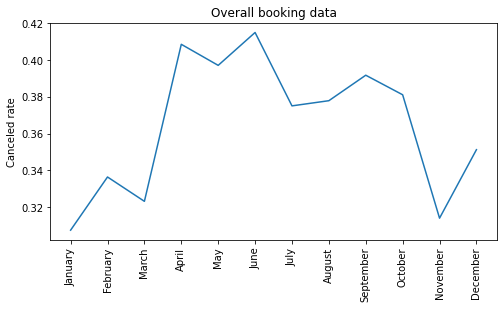

In [28]:
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
cancel_ratio=[]
for m in months:    
    ALL = booking_data_cleaned[booking_data_cleaned['arrival_date_month']== m]
    cancelled = Canceled_data[Canceled_data['arrival_date_month']== m]
    cancel_ratio.append(len(cancelled)/len(ALL))
monthly_canceled_ratio = [months,cancel_ratio]
plt.figure(figsize=(8,4))
plt.plot(monthly_canceled_ratio[0], monthly_canceled_ratio[1])
plt.xticks(rotation = 90)
plt.ylabel("Canceled rate")
plt.title("Overall booking data")
plt.show()

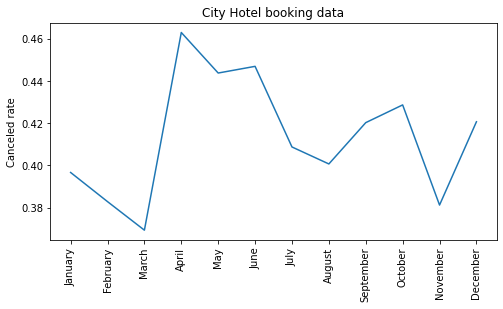

In [29]:
cancel_ratio=[]
for m in months:    
    ALL = City_Hotel_data[City_Hotel_data['arrival_date_month']== m]
    cancelled = City_Hotel_canceled[City_Hotel_canceled['arrival_date_month']== m]
    cancel_ratio.append(len(cancelled)/len(ALL))
monthly_canceled_ratio = [months,cancel_ratio]
plt.figure(figsize=(8,4))
plt.plot(monthly_canceled_ratio[0], monthly_canceled_ratio[1])
plt.xticks(rotation = 90)
plt.ylabel("Canceled rate")
plt.title("City Hotel booking data")
plt.show()

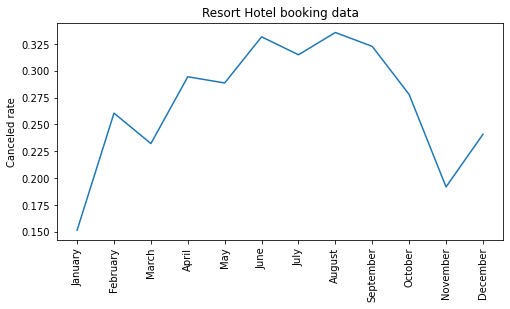

In [30]:
cancel_ratio=[]
for m in months:    
    ALL = Resort_Hotel_data[Resort_Hotel_data['arrival_date_month']== m]
    cancelled = Resort_Hotel_canceled[Resort_Hotel_canceled['arrival_date_month']== m]
    cancel_ratio.append(len(cancelled)/len(ALL))
monthly_canceled_ratio = [months,cancel_ratio]
plt.figure(figsize=(8,4))
plt.plot(monthly_canceled_ratio[0], monthly_canceled_ratio[1])
plt.xticks(rotation = 90)
plt.ylabel("Canceled rate")
plt.title("Resort Hotel booking data")
plt.show()

Here we try to produce every comination of graph that can somehow tell information.
Looking at the graphs, we try to find the difference (in terms of value or distribution) between canceled and non-canceled data.

In [31]:
booking_data_cleaned_adr.loc[booking_data_cleaned_adr['agent'] > 0, 'agent'] = 'yes'
booking_data_cleaned_adr['agent'].fillna(0, inplace = True)

In [32]:
booking_data_cleaned_adr.loc[booking_data_cleaned_adr['company'] > 0, 'company'] = 'yes'
booking_data_cleaned_adr['company'].fillna(0, inplace = True)

#### All data (Resort hotel + City hotel)

From the box plot of "lead_time", we can see that the distribution of the value of each transaction between canceled and non-canceled ones are different, with the canceled ones being more concentrated around 100 and the non-canceled ones being more concentrated around 70 while still have extreme values.

From the box plot of the "adr", the distribution is pretty similar.

From the box plot of the "stays_in_weekend_nights" and "stays_in_week_nights", the distribution is pretty similar.

From the box plot of the "adults", we can see that for the transactions that are canceled, a lot of them indicates that the order is for several adults, with the possibility of up to 50 people. In other words, a lot of these transactions are groups of people.

From the box plot of the "children", we can see that for the transactions that are canceled, some of them includes more than 4 children, which comes from the Resort hotel data because the distribution of children in City hotel data are more or less the same.

From the box plot of the "babies", we can see two transactions with over 8 or even 10 babies that are not canceled.

From the box plot of the "previous_cancellations", we can see that for the transactions that are not canceled, there are only some data points that are non-zero (542 points). For the transactions that are canceled, there are more data points that are non-zero (5942 points), but concentrated at a low value (mainly 1).

From the box plot of the "previous_bookings_not_canceled", for the transactions that are canceled, only 200 data points have non-zero "previous_bookings_not_canceled" value, while for the transactions that are not canceled, there are 3231 data points having non-zero "previous_bookings_not_canceled" value, and most of them have higher value than the canceled ones.

From the box plot of the "bookings_changes", for the transactions that are not canceled, there are 15243 data points having non-zero "bookings_changes" values, while for for the transactions that are canceled, there are only 2833 having non-zero "bookings_changes" values, and some even around 5 to 20 booking changes.

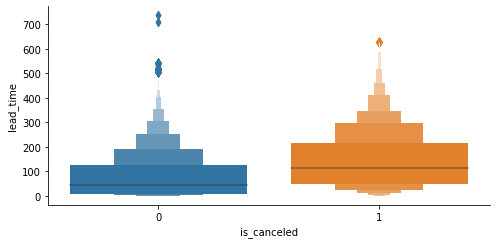

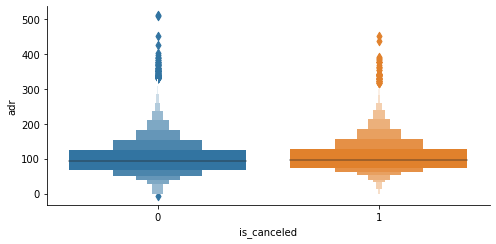

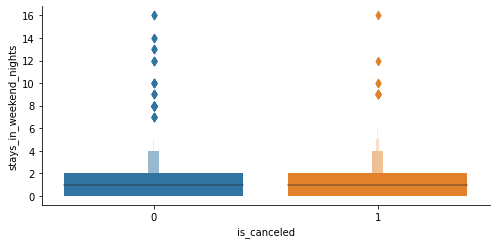

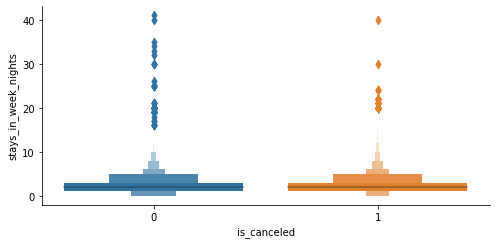

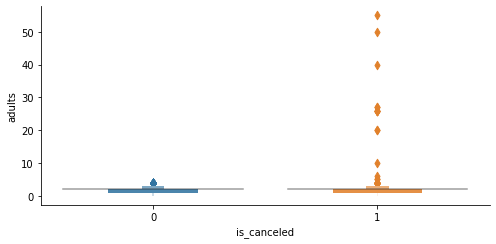

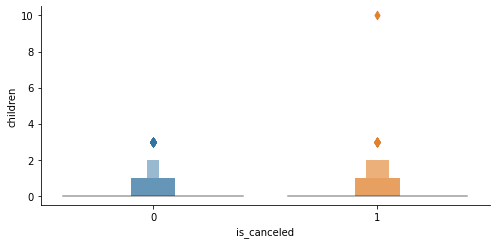

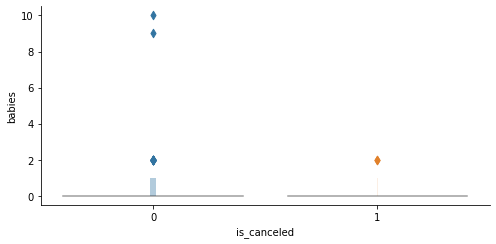

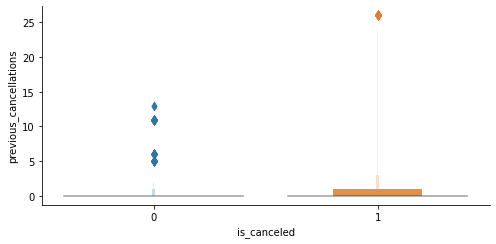

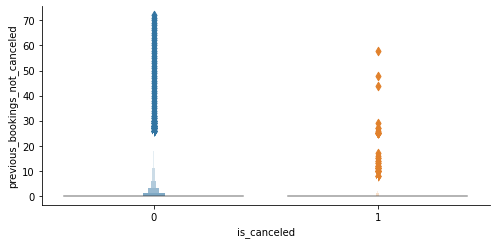

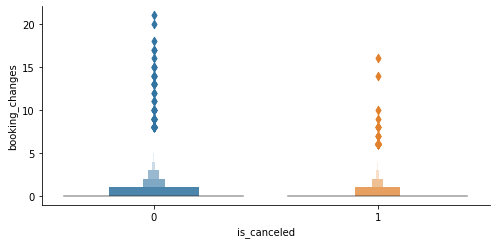

In [33]:
continuous_features = ["lead_time","adr", "stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","previous_cancellations","previous_bookings_not_canceled","booking_changes"]
for feature in continuous_features:
    sns.catplot(y=feature,x="is_canceled",data=booking_data_cleaned_adr,kind="boxen",height=3.5, aspect=2)
    plt.show()

From the bar chart of the "arrival_date_month", indicating the arrivial month, the distribution of canceled and not canceled number of transactions are similar, with July and August having the most orders.

From the bar chart of the "market_segment", we can see that the main market of both canceled and non-canceled transactions is online travel agent. However, for the one that is canceled, the second highest market is from groups customers then offline travel agent/tour operator and direct customers are far less than the two. While for the transactions that are not canceled, the second highest is offline travel agent/tour operator than comes direct customers.

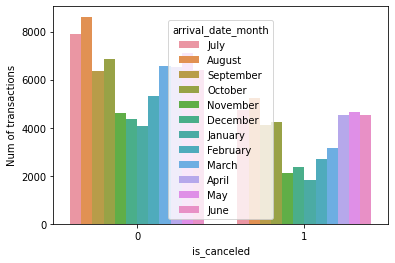

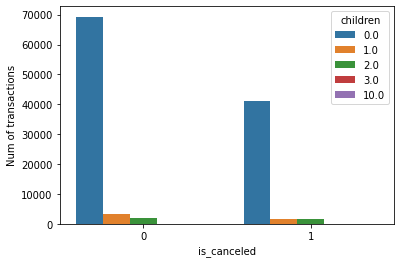

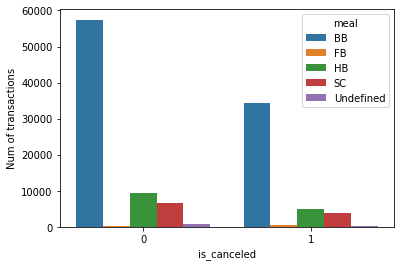

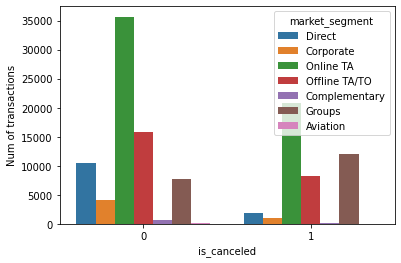

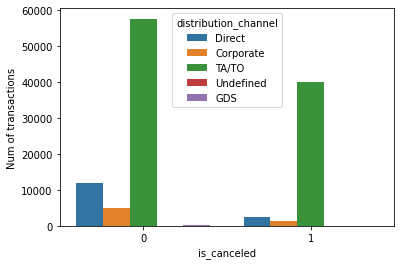

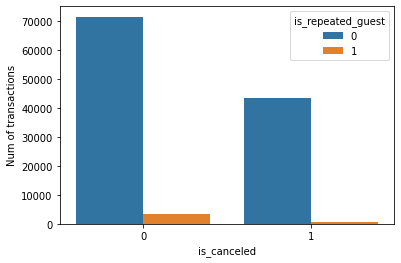

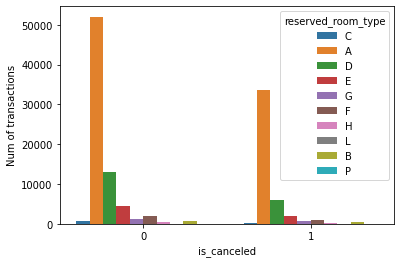

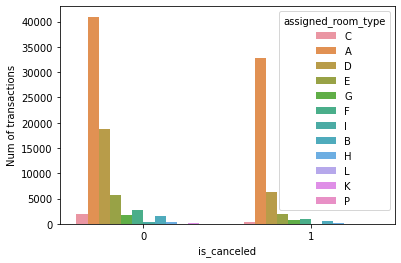

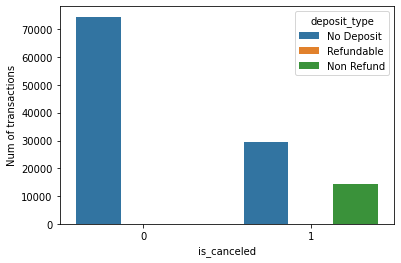

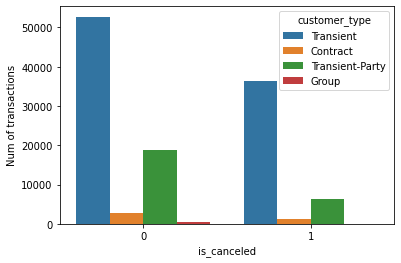

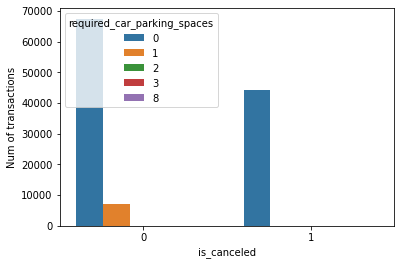

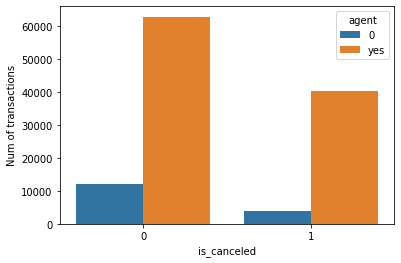

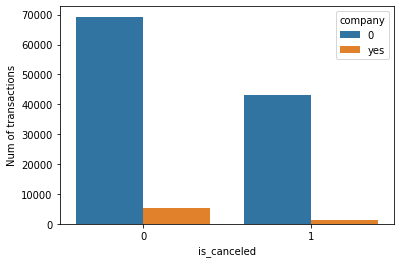

In [34]:
categorical_features = ["arrival_date_month","children","meal","market_segment","distribution_channel","is_repeated_guest","reserved_room_type","assigned_room_type","deposit_type","customer_type","required_car_parking_spaces","agent","company"]
for feature in categorical_features:
    ax = sns.countplot(data=booking_data_cleaned_adr, x='is_canceled', hue=feature)   
    ax.set(xlabel='is_canceled', ylabel='Num of transactions')
    plt.show()

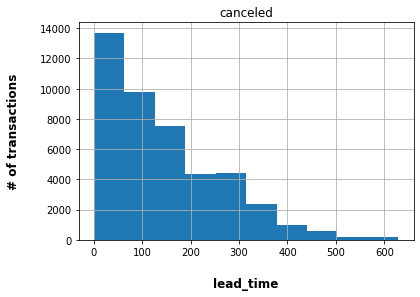

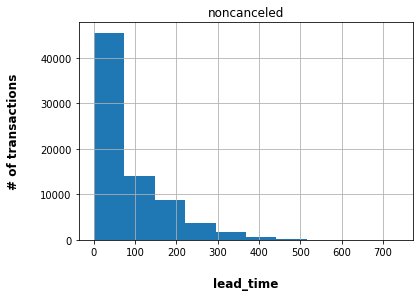

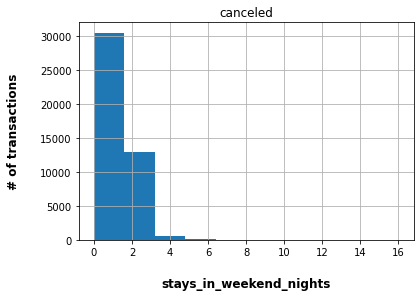

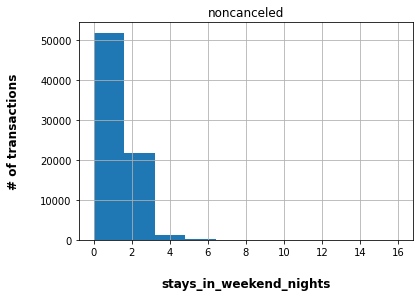

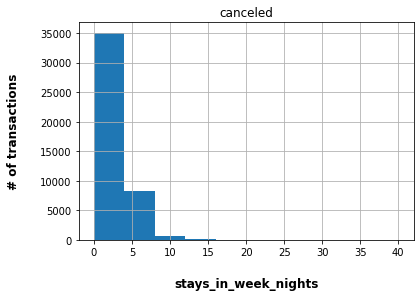

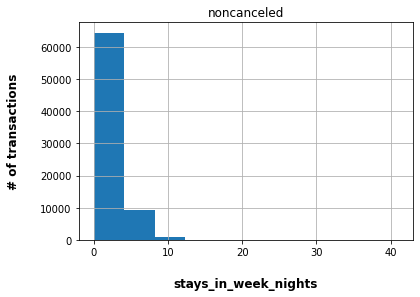

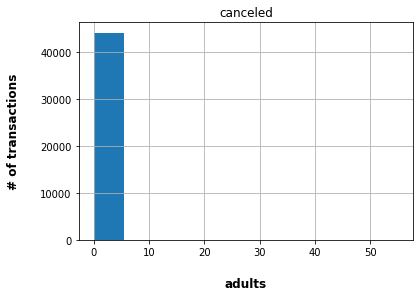

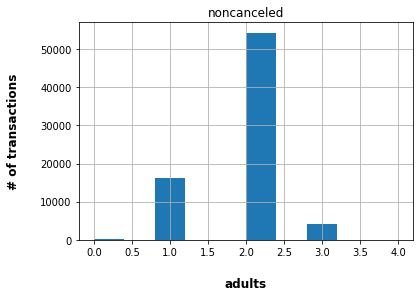

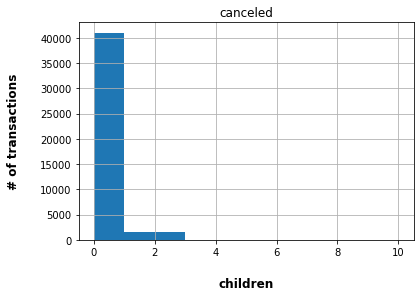

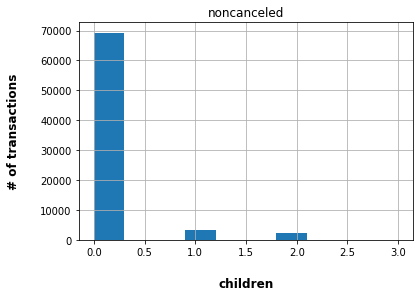

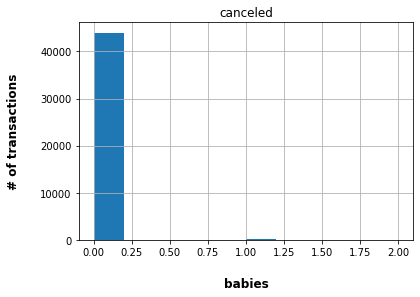

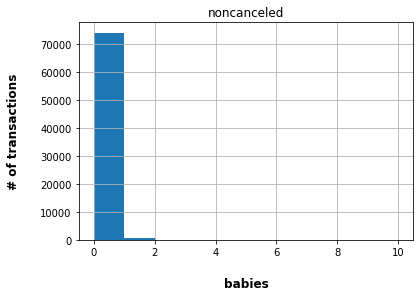

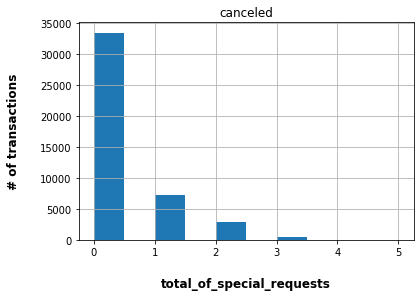

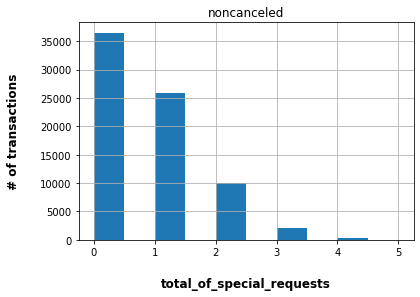

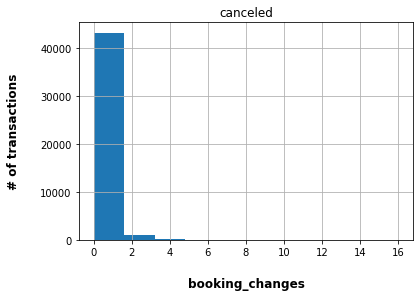

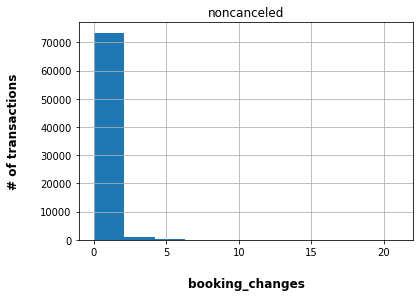

In [35]:
historgram_features = ["lead_time", "stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","total_of_special_requests","booking_changes"]
booking_data_canceled = booking_data_cleaned_adr[booking_data_cleaned_adr['is_canceled']==1]
booking_data_noncanceled = booking_data_cleaned_adr[booking_data_cleaned_adr['is_canceled']==0]
for feature in historgram_features:
    ax1 = booking_data_canceled.hist(column=feature, bins=10)
    ax1 = ax1[0]
    for x in ax1:
        x.set_title("canceled")
        x.set_xlabel(feature, labelpad=20, weight='bold', size=12)
        x.set_ylabel("# of transactions", labelpad=20, weight='bold', size=12)
    ax2 = booking_data_noncanceled.hist(column=feature, bins=10)
    ax2 = ax2[0]
    for x in ax2:
        x.set_title("noncanceled")
        x.set_xlabel(feature, labelpad=20, weight='bold', size=12)
        x.set_ylabel("# of transactions", labelpad=20, weight='bold', size=12)

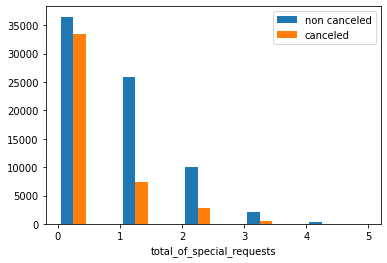

In [36]:
joint_historgram_features = ["total_of_special_requests"]
for feature in joint_historgram_features:    
    a = booking_data_noncanceled[feature].to_numpy()
    b = booking_data_canceled[feature].to_numpy()
    plt.hist([a, b], label=['non canceled', 'canceled'])
    plt.legend(loc='upper right')
    plt.xlabel(feature)
    plt.show()

#### Resort hotel data

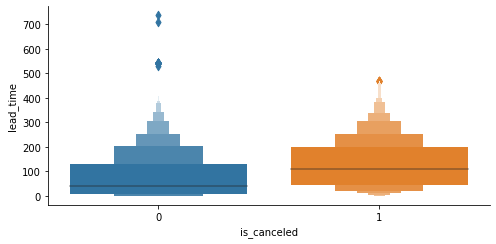

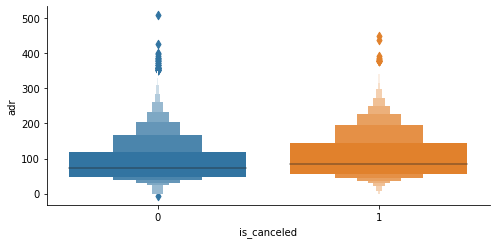

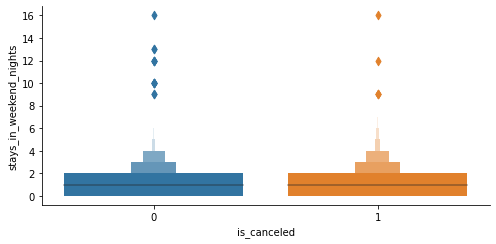

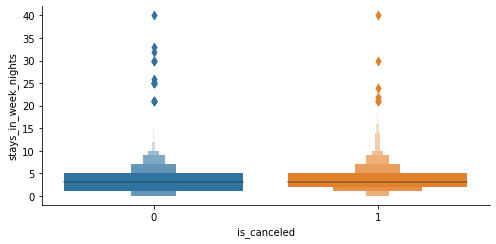

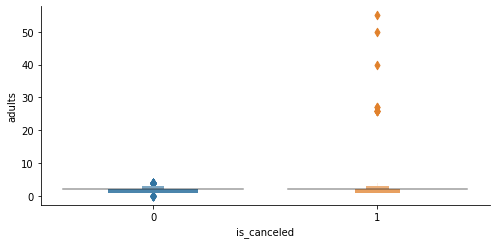

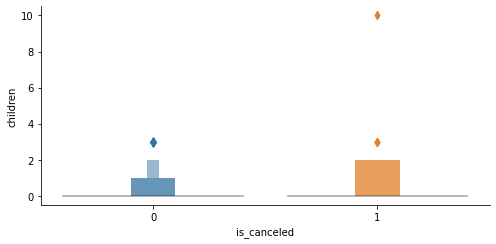

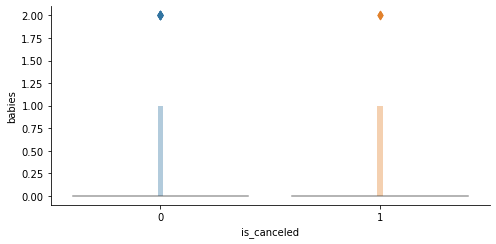

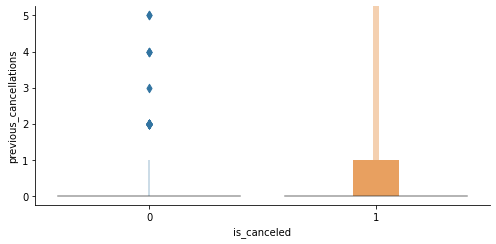

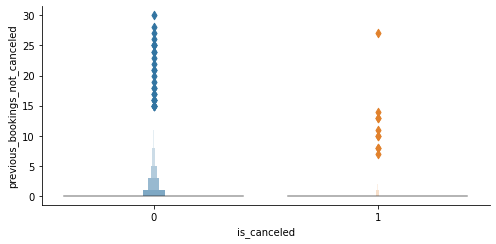

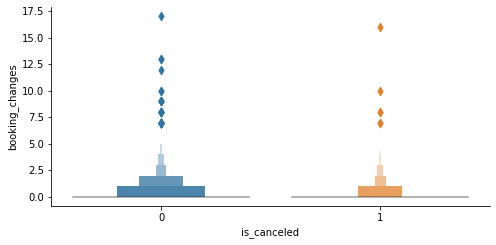

In [37]:
continuous_features = ["lead_time","adr", "stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","previous_cancellations","previous_bookings_not_canceled","booking_changes"]
for feature in continuous_features:
    sns.catplot(y=feature,x="is_canceled",data=Resort_Hotel_data,kind="boxen",height=3.5, aspect=2)
    plt.show()

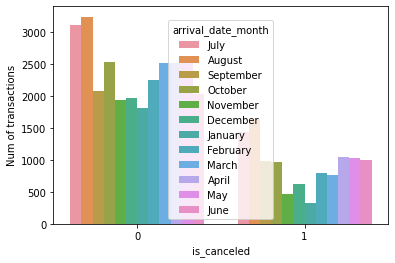

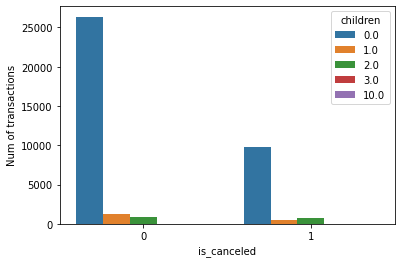

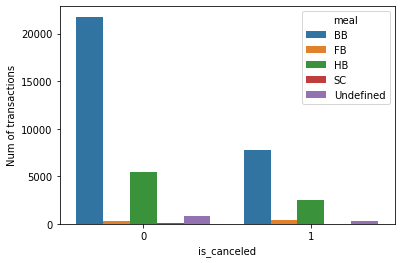

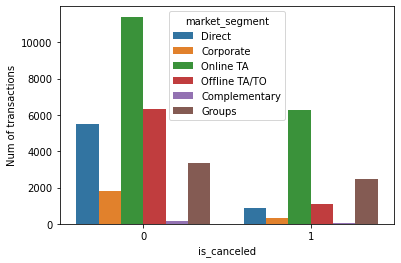

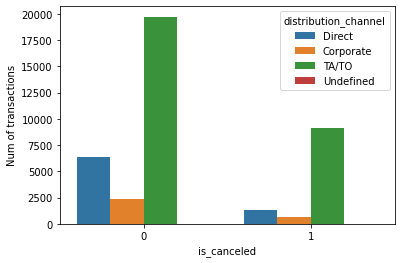

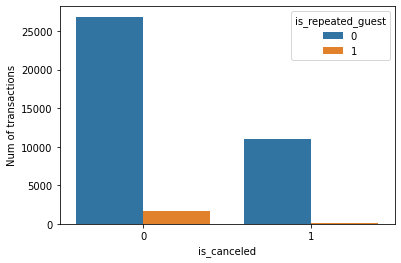

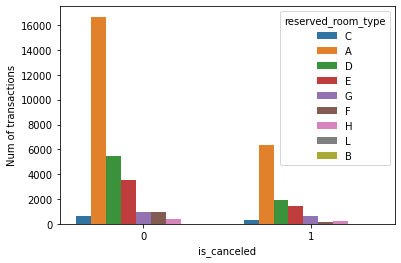

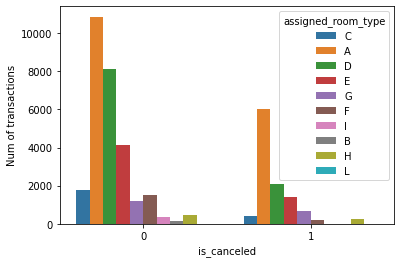

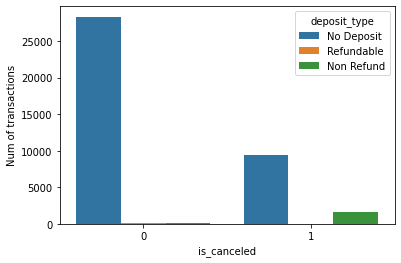

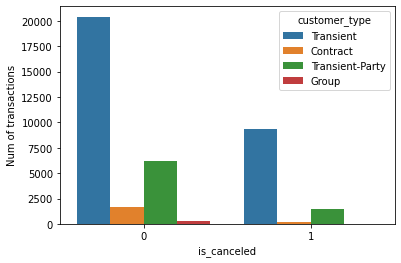

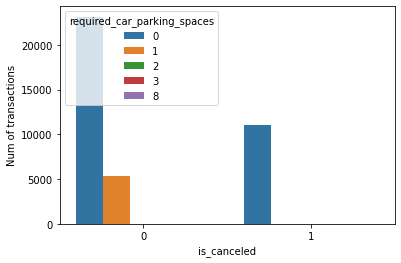

In [38]:
categorical_features = ["arrival_date_month","children","meal","market_segment","distribution_channel","is_repeated_guest","reserved_room_type","assigned_room_type","deposit_type","customer_type","required_car_parking_spaces"]
for feature in categorical_features:
    ax = sns.countplot(data=Resort_Hotel_data, x='is_canceled', hue=feature)   
    ax.set(xlabel='is_canceled', ylabel='Num of transactions')
    plt.show()

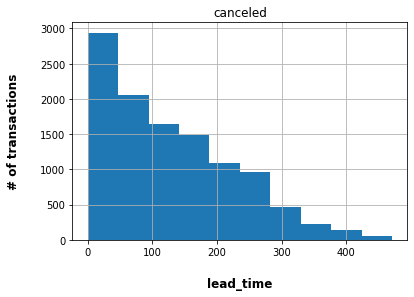

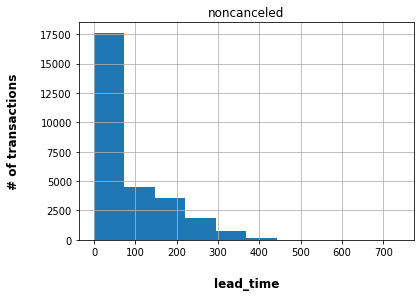

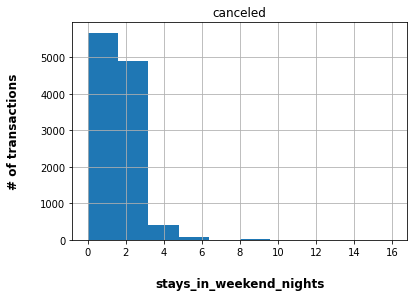

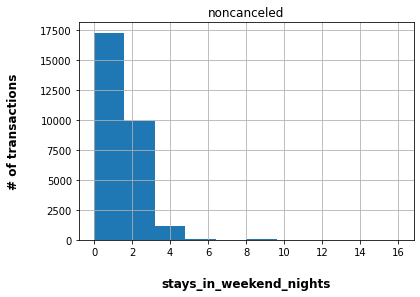

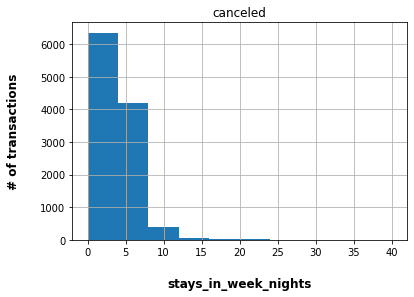

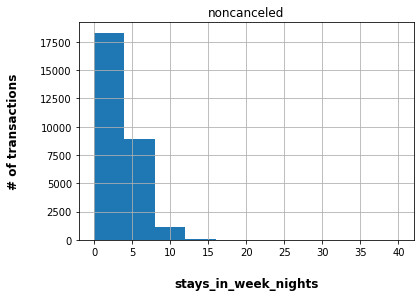

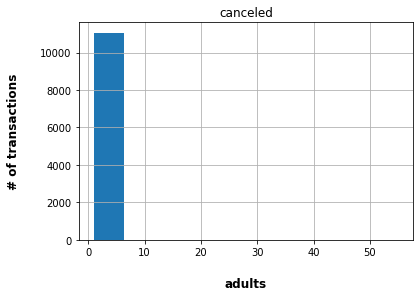

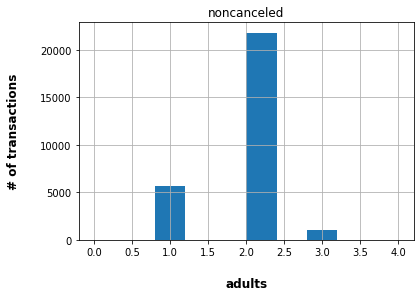

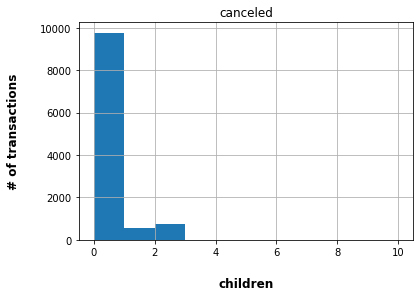

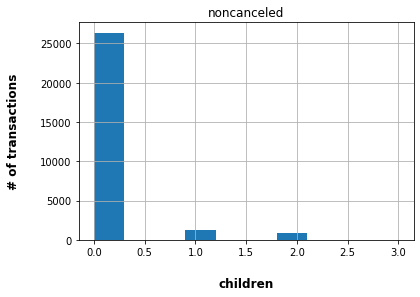

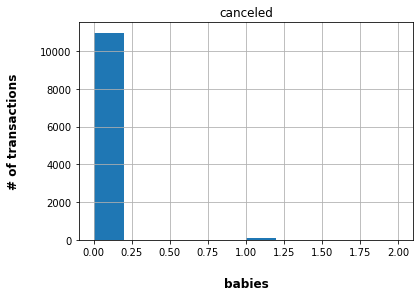

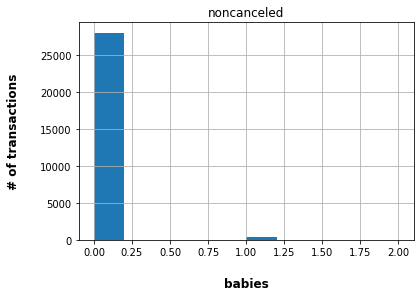

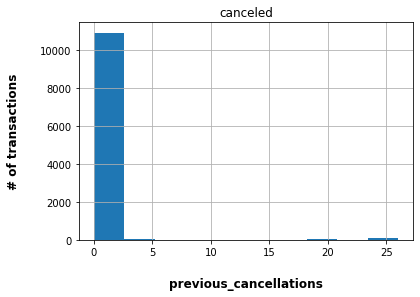

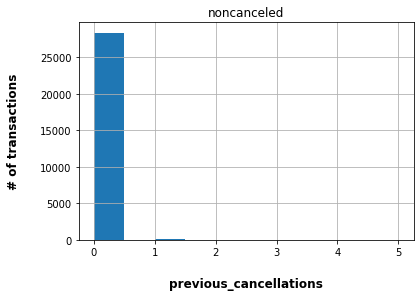

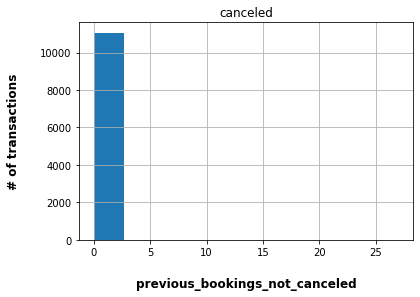

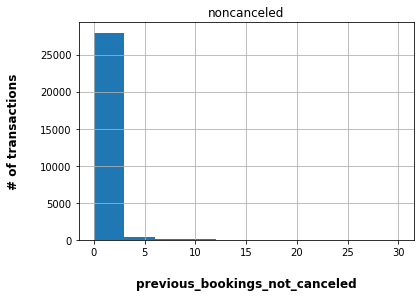

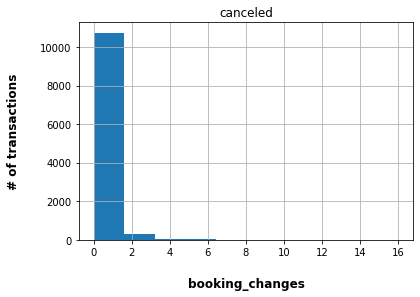

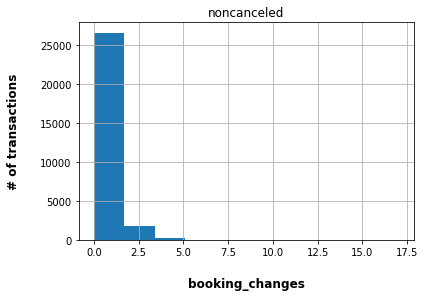

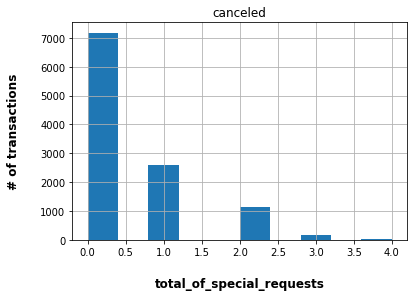

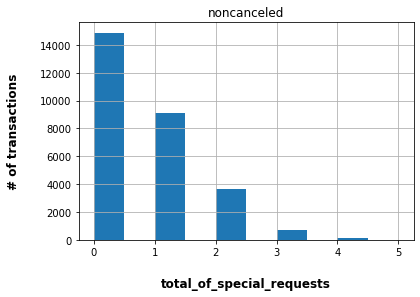

In [39]:
historgram_features = ["lead_time", "stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","previous_cancellations","previous_bookings_not_canceled","booking_changes","total_of_special_requests"]
Resort_Hotel_canceled = Resort_Hotel_data[Resort_Hotel_data['is_canceled']==1]
Resort_Hotel_noncanceled = Resort_Hotel_data[Resort_Hotel_data['is_canceled']==0]
for feature in historgram_features:
    ax1 = Resort_Hotel_canceled.hist(column=feature, bins=10)
    ax1 = ax1[0]
    for x in ax1:
        x.set_title("canceled")
        x.set_xlabel(feature, labelpad=20, weight='bold', size=12)
        x.set_ylabel("# of transactions", labelpad=20, weight='bold', size=12)
    ax2 = Resort_Hotel_noncanceled.hist(column=feature, bins=10)
    ax2 = ax2[0]
    for x in ax2:
        x.set_title("noncanceled")
        x.set_xlabel(feature, labelpad=20, weight='bold', size=12)
        x.set_ylabel("# of transactions", labelpad=20, weight='bold', size=12)

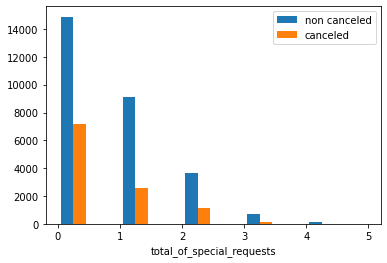

In [40]:
joint_historgram_features = ["total_of_special_requests"]
for feature in joint_historgram_features:    
    a = Resort_Hotel_noncanceled[feature].to_numpy()
    b = Resort_Hotel_canceled[feature].to_numpy()
    plt.hist([a, b], label=['non canceled', 'canceled'])
    plt.legend(loc='upper right')
    plt.xlabel(feature)
    plt.show()

#### City hotel data

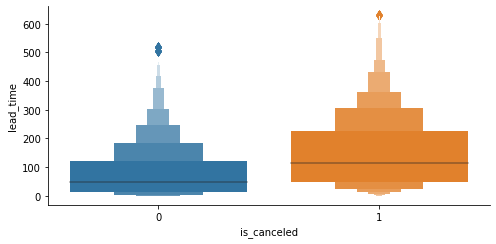

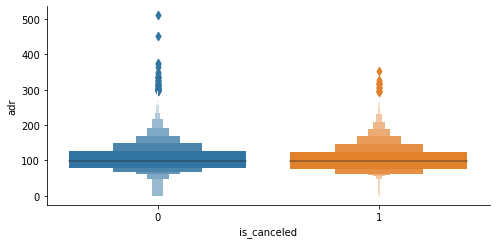

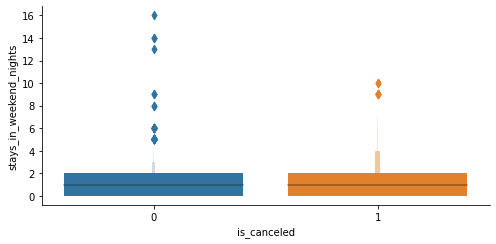

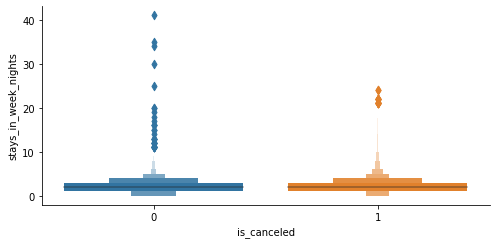

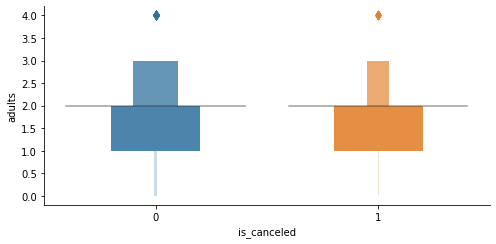

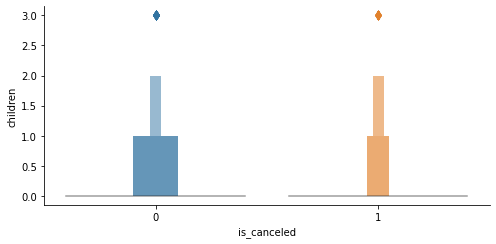

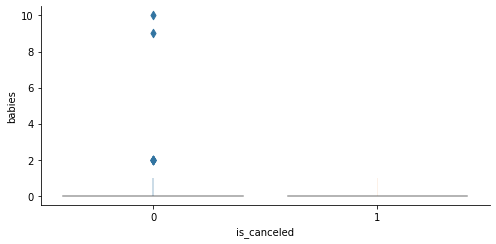

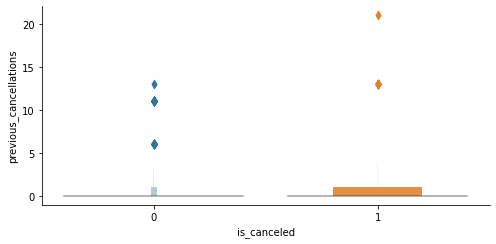

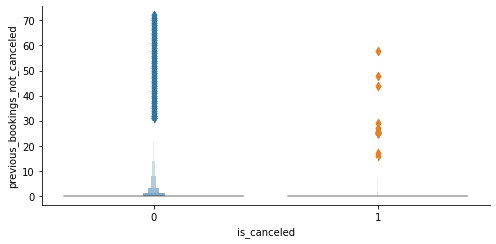

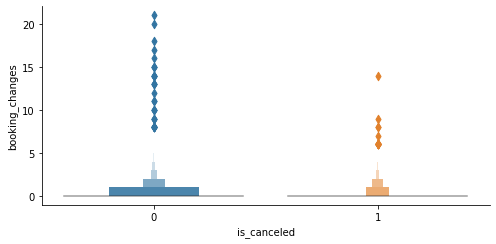

In [41]:
continuous_features = ["lead_time","adr", "stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","previous_cancellations","previous_bookings_not_canceled","booking_changes"]
for feature in continuous_features:
    sns.catplot(y=feature,x="is_canceled",data=City_Hotel_data,kind="boxen",height=3.5, aspect=2)
    plt.show()

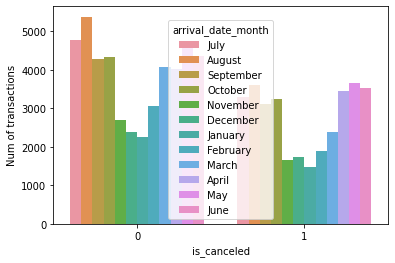

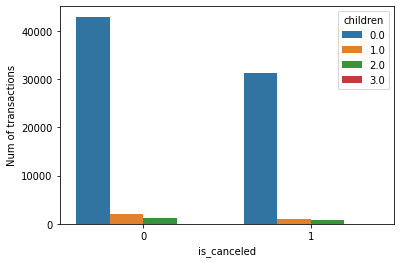

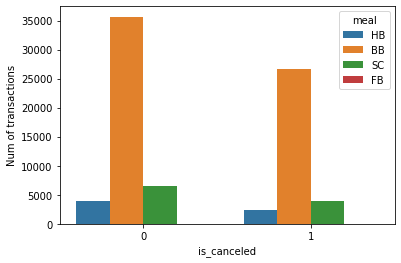

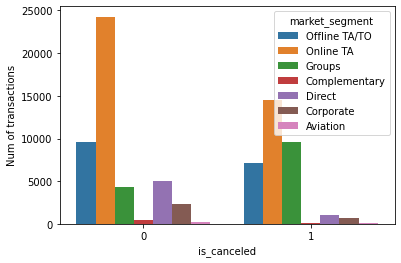

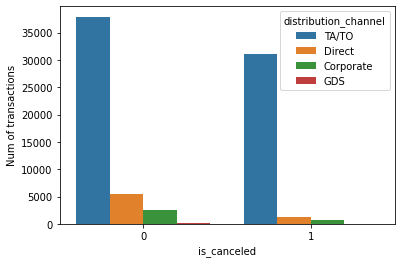

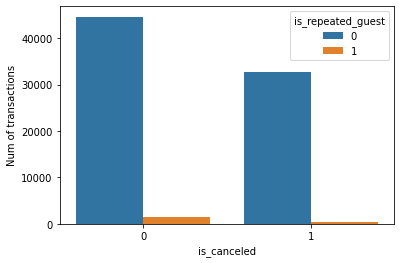

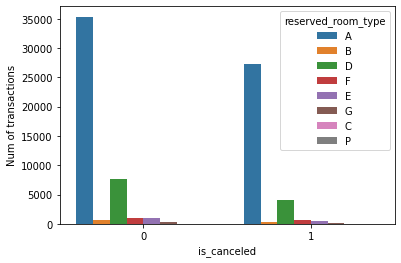

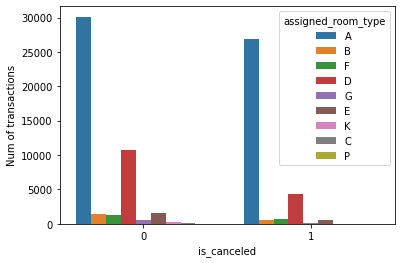

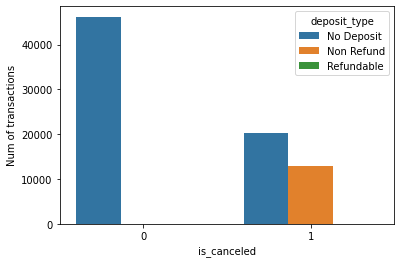

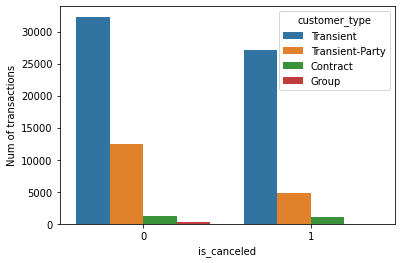

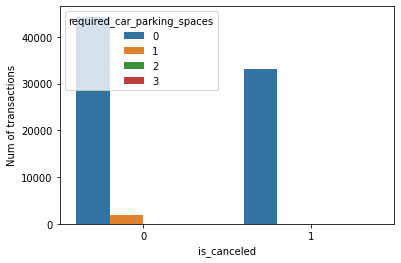

In [42]:
categorical_features = ["arrival_date_month","children","meal","market_segment","distribution_channel","is_repeated_guest","reserved_room_type","assigned_room_type","deposit_type","customer_type","required_car_parking_spaces"]
for feature in categorical_features:
    ax = sns.countplot(data=City_Hotel_data, x='is_canceled', hue=feature)   
    ax.set(xlabel='is_canceled', ylabel='Num of transactions')
    plt.show()

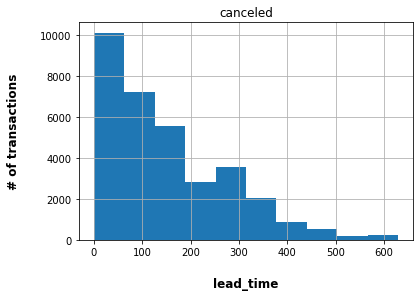

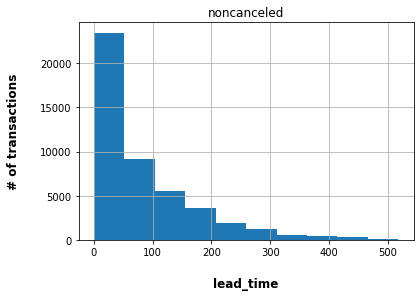

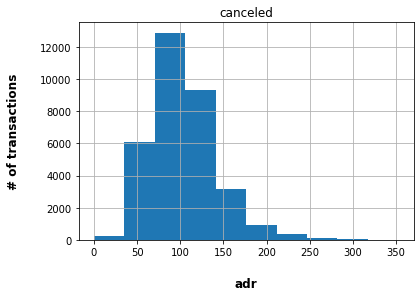

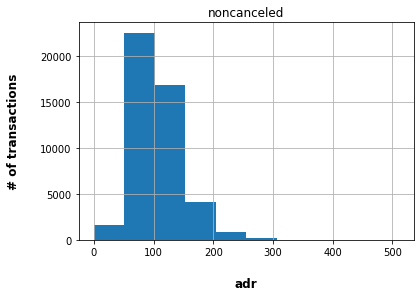

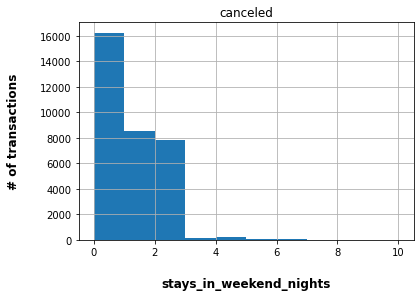

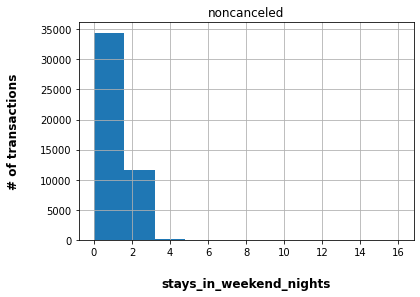

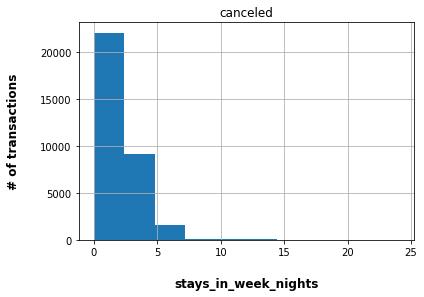

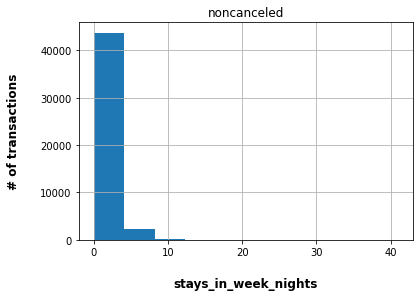

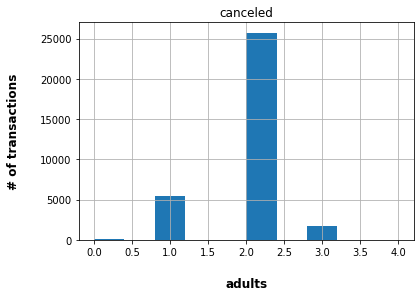

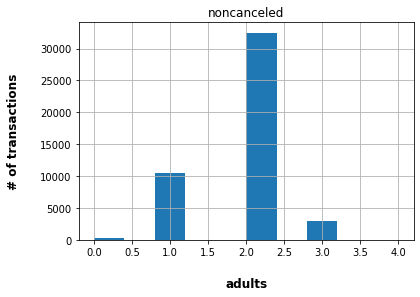

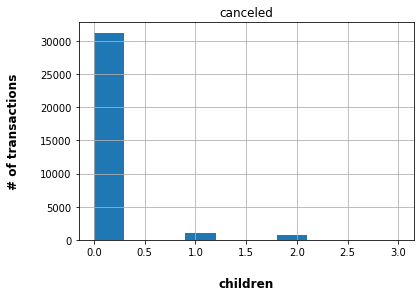

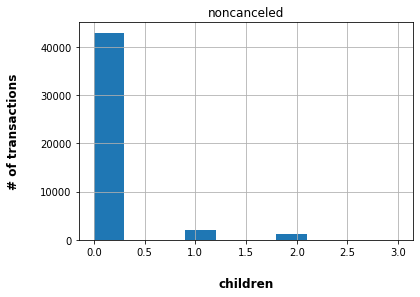

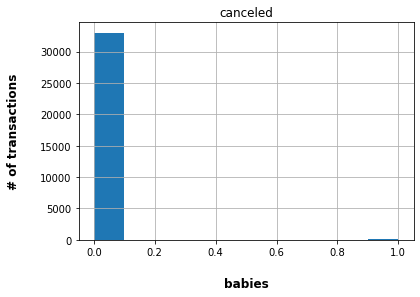

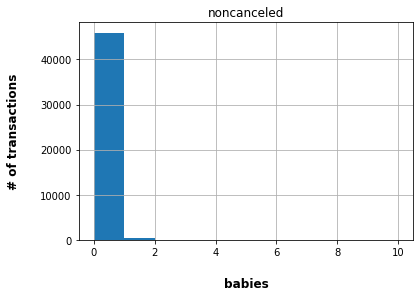

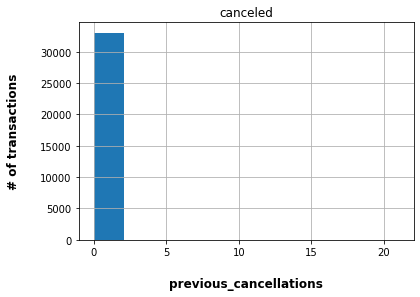

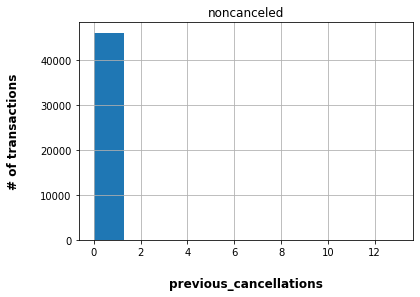

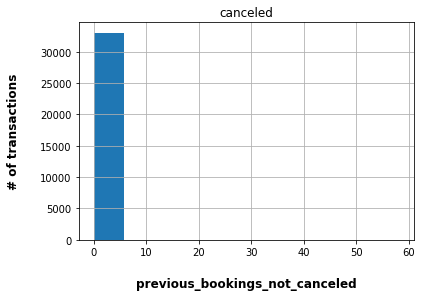

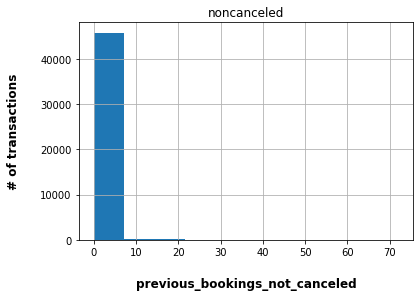

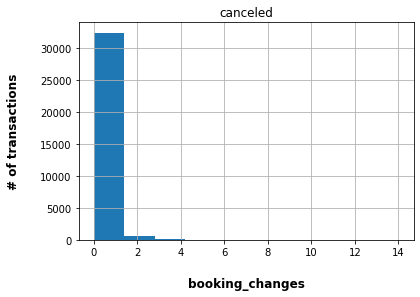

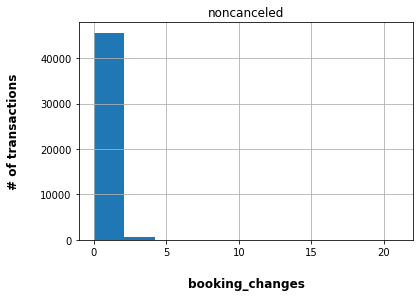

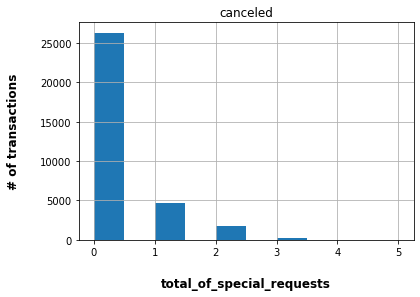

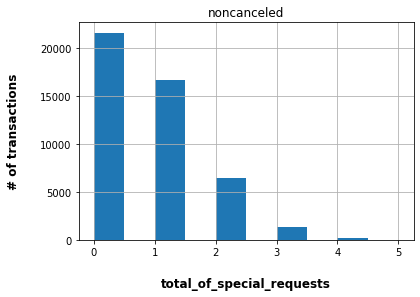

In [43]:
historgram_features = ["lead_time","adr", "stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","previous_cancellations","previous_bookings_not_canceled","booking_changes","total_of_special_requests"]
City_Hotel_canceled = City_Hotel_data[City_Hotel_data['is_canceled']==1]
City_Hotel_noncanceled = City_Hotel_data[City_Hotel_data['is_canceled']==0]
for feature in historgram_features:
    ax1 = City_Hotel_canceled.hist(column=feature, bins=10)
    ax1 = ax1[0]
    for x in ax1:
        x.set_title("canceled")
        x.set_xlabel(feature, labelpad=20, weight='bold', size=12)
        x.set_ylabel("# of transactions", labelpad=20, weight='bold', size=12)
    ax2 = City_Hotel_noncanceled.hist(column=feature, bins=10)
    ax2 = ax2[0]
    for x in ax2:
        x.set_title("noncanceled")
        x.set_xlabel(feature, labelpad=20, weight='bold', size=12)
        x.set_ylabel("# of transactions", labelpad=20, weight='bold', size=12)

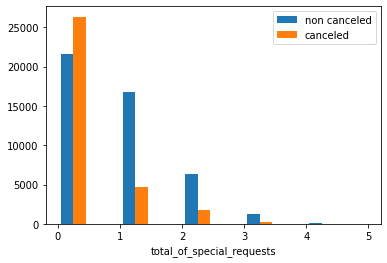

In [44]:
joint_historgram_features = ["total_of_special_requests"]
for feature in joint_historgram_features:    
    a = City_Hotel_noncanceled[feature].to_numpy()
    b = City_Hotel_canceled[feature].to_numpy()
    plt.hist([a, b], label=['non canceled', 'canceled'])
    plt.legend(loc='upper right')
    plt.xlabel(feature)
    plt.show()

---

### 3. Feature Engineering

In [45]:
try:
    import tensorflow as tf
    from tensorflow.keras import layers
    from tensorflow import feature_column
except:
    !conda install -c conda-forge tensorflow=2.0.0 -y
tf.random.set_seed(5)

In [46]:
def drop_col(df, col_name):
    try:
        df = df.drop(columns=[col_name], inplace=True)
    except:
        print('{} had been dropped'.format(col_name))

In [47]:
drop_col(booking_data_cleaned, 'country')

In [48]:
booking_data_cleaned = booking_data_cleaned.fillna(0)
booking_data_cleaned.loc[:, ['agent', 'company']].isna().any()

agent      False
company    False
dtype: bool

In [49]:
booking_data_cleaned.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

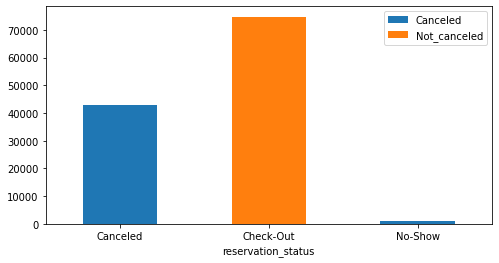

In [50]:
df_temp = booking_data_cleaned.loc[:, ['is_canceled', 'reservation_status']]
df_temp['not_canceled'] = -df_temp.is_canceled + 1
df_temp.columns = ['Canceled', 'reservation_status', 'Not_canceled']
df_temp = df_temp.pivot_table(values=['Canceled', 'Not_canceled'], index='reservation_status', aggfunc='sum')
df_temp.plot.bar(stacked=True, figsize=(8, 4), rot=0)
plt.show()

In [51]:
drop_col(booking_data_cleaned, 'reservation_status')
drop_col(booking_data_cleaned, 'reservation_status_date')

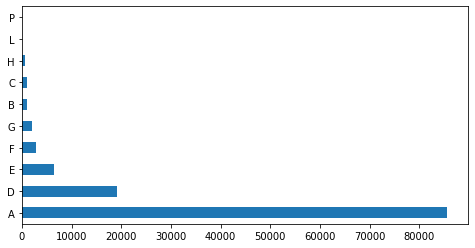

In [52]:
booking_data_cleaned.reserved_room_type.value_counts().plot(kind='barh', figsize=(8, 4))
plt.show()                                                            

In [53]:
type_order = list(booking_data_cleaned.reserved_room_type.value_counts().index)
type_order

['A', 'D', 'E', 'F', 'G', 'B', 'C', 'H', 'L', 'P']

In [54]:
for i in type_order:
    temp = booking_data_cleaned[booking_data_cleaned.reserved_room_type == i].assigned_room_type
    print(list(temp.value_counts().index))

['A', 'D', 'C', 'E', 'B', 'F', 'I', 'K', 'G', 'H']
['D', 'E', 'A', 'F', 'G', 'I', 'K', 'C', 'B', 'H']
['E', 'F', 'G', 'I', 'D', 'K', 'A', 'C', 'H', 'B']
['F', 'G', 'E', 'B', 'I', 'A', 'D', 'K', 'H']
['G', 'I', 'F', 'H', 'A', 'K', 'E', 'B', 'C']
['B', 'A', 'G', 'D', 'K', 'F', 'E']
['C', 'H', 'G', 'I', 'D', 'A', 'E', 'B', 'F']
['H', 'G', 'I', 'D']
['H', 'B', 'F', 'A', 'C', 'L']
['P']


In [55]:
type_order = ['K'] + type_order + ['I']
print(type_order)
booking_data_cleaned.reserved_room_type = booking_data_cleaned.reserved_room_type.apply(lambda x: type_order.index(x))
booking_data_cleaned.assigned_room_type = booking_data_cleaned.assigned_room_type.apply(lambda x: type_order.index(x))

['K', 'A', 'D', 'E', 'F', 'G', 'B', 'C', 'H', 'L', 'P', 'I']


In [56]:
booking_data_cleaned = booking_data_cleaned.astype({'reserved_room_type':'int', 'assigned_room_type': 'int'})

In [57]:
booking_data_cleaned['upgrade'] = booking_data_cleaned.reserved_room_type < booking_data_cleaned.assigned_room_type
booking_data_cleaned['downgrade'] = booking_data_cleaned.reserved_room_type > booking_data_cleaned.assigned_room_type
booking_data_cleaned['change_direct'] = booking_data_cleaned.upgrade.apply(int) - booking_data_cleaned.downgrade.apply(int)
booking_data_cleaned = booking_data_cleaned.drop(columns=['upgrade', 'downgrade', 'assigned_room_type'])

In [58]:
booking_data_cleaned = booking_data_cleaned.drop(columns=['arrival_date_year', 'arrival_date_week_number'])

In [59]:
booking_data_cleaned['hotel'] = booking_data_cleaned.hotel == 'Resort Hotel'
booking_data_cleaned['agent'] = booking_data_cleaned.agent > 0
booking_data_cleaned['company'] = booking_data_cleaned.company > 0

In [60]:
binary = ['hotel', 'is_repeated_guest', 'agent', 'company']
onehot = ['meal', 'market_segment', 'distribution_channel', 'deposit_type', 'reserved_room_type', 'customer_type', 'change_direct']
embedding = ['arrival_date_month', 'arrival_date_day_of_month']
numeric = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
          'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

In [61]:
for i in [numeric, binary]:
    booking_data_cleaned[i] = booking_data_cleaned[i].astype(np.float32)

In [62]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    dataframe = dataframe.copy()
    labels = dataframe.pop('is_canceled')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [63]:
train_val, test = train_test_split(booking_data_cleaned, test_size=0.2)
train, validation = train_test_split(train_val, test_size=0.2)

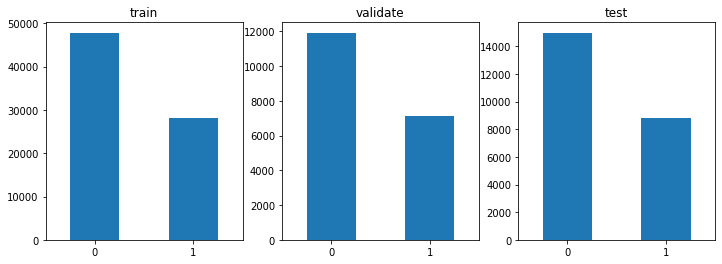

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
train['is_canceled'].value_counts().plot(kind='bar', rot=0)
plt.title('train')

plt.subplot(1, 3, 2)
validation['is_canceled'].value_counts().plot(kind='bar', rot=0)
plt.title('validate')

plt.subplot(1, 3, 3)
test['is_canceled'].value_counts().plot(kind='bar', rot=0)
plt.title('test')
plt.show()

In [65]:
all_mean = np.mean(train, axis=0)
all_std = np.std(train, axis=0) + 1e-7

In [66]:
for i in numeric:
    train[i] = (train[i] - all_mean[i]) / all_std[i]
    validation[i] = (validation[i] - all_mean[i]) / all_std[i]
    test[i] = (test[i] - all_mean[i]) / all_std[i]

In [67]:
train_ds = df_to_dataset(train, shuffle=True, batch_size = len(train))
val_ds = df_to_dataset(validation, shuffle=True, batch_size = len(validation))
test_ds = df_to_dataset(test, shuffle=True, batch_size = len(test))

In [68]:
train_ds = [x for x in train_ds.take(1)][0]
val_ds = [x for x in val_ds.take(1)][0]
test_ds = [x for x in test_ds.take(1)][0]

In [69]:
def get_dense_features(dataset, f_col):
    densify = layers.DenseFeatures(f_col)
    return densify(dataset).numpy()

In [77]:
feature_columns = []
from collections import defaultdict
ds_numpy = defaultdict(dict)
keys = ['train', 'validation', 'test']

for k, tfset in zip(keys, [train_ds, val_ds, test_ds]):
    ds_numpy[k]['label'] = tfset[1].numpy()

for i in binary:
    feature_columns.append(feature_column.numeric_column(i))
    for k, tfset in zip(keys, [train_ds, val_ds, test_ds]):
        ds_numpy[k][feature_columns[-1].key] = get_dense_features(tfset[0], f_col=feature_columns[-1]).squeeze(axis=1)

for i in numeric:
    feature_columns.append(feature_column.numeric_column(i))
    for k, tfset in zip(keys, [train_ds, val_ds, test_ds]):
        ds_numpy[k][feature_columns[-1].key] = get_dense_features(tfset[0], f_col=feature_columns[-1]).squeeze(axis=1)

for i in onehot:
    col = feature_column.indicator_column(feature_column.categorical_column_with_vocabulary_list(i, sorted(pd.unique(booking_data_cleaned[i]))))
    feature_columns.append(col)
    for k, tfset in zip(keys, [train_ds, val_ds, test_ds]):
        vocal = feature_columns[-1].categorical_column.vocabulary_list
        name = feature_columns[-1].categorical_column.key
        f = get_dense_features(tfset[0], f_col=feature_columns[-1])
        for idx, v in enumerate(vocal):
            ds_numpy[k][name + '_' + str(v)] = f[:, idx]

for i in embedding:
    dim = np.log2(len(pd.unique(booking_data_cleaned[i])))
    dim = int(dim)
    col = feature_column.embedding_column(feature_column.categorical_column_with_vocabulary_list(i, sorted(pd.unique(booking_data_cleaned[i]))), dimension=dim)
    feature_columns.append(col)
    for k, tfset in zip(keys, [train_ds, val_ds, test_ds]):
        vocal = list(range(dim))
        name = feature_columns[-1].categorical_column.key
        f = get_dense_features(tfset[0], f_col=feature_columns[-1])
        for idx, v in enumerate(vocal):
            ds_numpy[k][str(name) + '_' + str(v)] = f[:, idx]

---

### 4. Supervised machine learning

In this part, we train several classifiers and try to find the most suitable one. If there are some parameters in the model, we use cross validation to tune the hyper-parameter based on F1 score as the metric. 

In [78]:
# Prepare the data for training
dataset_feature_engineering = ds_numpy
ds_numpy.keys()

dict_keys(['train', 'validation', 'test'])

In [79]:
# Prepare the data for training
train_ds = df_to_dataset(train, shuffle=True, batch_size = len(train))
val_ds = df_to_dataset(validation, shuffle=True, batch_size = len(validation))
test_ds = df_to_dataset(test, shuffle=True, batch_size = len(test))

In [80]:
# Construct the dataframe for each set in order to correspond with the feature name
X_train = pd.DataFrame.from_dict(dataset_feature_engineering['train']).iloc[:,1:]
y_train = pd.DataFrame.from_dict(dataset_feature_engineering['train'])['label']
X_val = pd.DataFrame.from_dict(dataset_feature_engineering['validation']).iloc[:,1:]
y_val = pd.DataFrame.from_dict(dataset_feature_engineering['validation'])['label']
X_test = pd.DataFrame.from_dict(dataset_feature_engineering['test']).iloc[:,1:]
y_test = pd.DataFrame.from_dict(dataset_feature_engineering['test'])['label']

In [81]:
# The function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix):
    df_cm = pd.DataFrame(confusion_matrix, index=['Canceled','Not canceled'], columns=['Canceled','Not canceled'])
    fig = plt.figure(figsize=(5,4))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Greens')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=10)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
    plt.ylim(0, 2)
    plt.title('The confusion matrix of the predicted results',fontsize=10)
    plt.xlabel('Predicted label',fontsize=10)
    plt.ylabel('True label',fontsize=10)

### 4.1 Baseline model 1: Logistic regression

#### Training process

In [218]:
# Define the loss function
class BalancedEntropy(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        loss = - (1.7 * y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.math.reduce_mean(loss)

In [283]:
feature_densify = layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([feature_densify, layers.Dense(128, activation='tanh'), layers.Dense(1, activation='sigmoid')])

In [284]:
# Train the model with 200 epochs
model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=BalancedEntropy(), metrics=['accuracy', tf.keras.metrics.AUC()])
model_history = model.fit(train_ds, validation_data=val_ds, epochs=200)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/200
1/1 [==============================] - 15s 15s/step - loss: 0.8890 - accuracy: 0.4455 - auc_4: 0.4926 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc_4: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 9s 9s/step - loss: 0.8325 - accuracy: 0.6439 - auc_4: 0.6833 - val_loss: 0.7988 - val_accuracy: 0.6195 - val_auc_4: 0.7602
Epoch 3/200
1/1 [==============================] - 12s 12s/step - loss: 0.7991 - accuracy: 0.6159 - auc_4: 0.7576 - val_loss: 0.7750 - val_accurac

Epoch 44/200
1/1 [==============================] - 9s 9s/step - loss: 0.5887 - accuracy: 0.7838 - auc_4: 0.8571 - val_loss: 0.5892 - val_accuracy: 0.7639 - val_auc_4: 0.8560
Epoch 45/200
1/1 [==============================] - 9s 9s/step - loss: 0.5874 - accuracy: 0.7661 - auc_4: 0.8576 - val_loss: 0.5882 - val_accuracy: 0.7824 - val_auc_4: 0.8561
Epoch 46/200
1/1 [==============================] - 8s 8s/step - loss: 0.5861 - accuracy: 0.7827 - auc_4: 0.8578 - val_loss: 0.5869 - val_accuracy: 0.7666 - val_auc_4: 0.8566
Epoch 47/200
1/1 [==============================] - 8s 8s/step - loss: 0.5849 - accuracy: 0.7687 - auc_4: 0.8583 - val_loss: 0.5860 - val_accuracy: 0.7820 - val_auc_4: 0.8568
Epoch 48/200
1/1 [==============================] - 8s 8s/step - loss: 0.5838 - accuracy: 0.7824 - auc_4: 0.8586 - val_loss: 0.5848 - val_accuracy: 0.7696 - val_auc_4: 0.8573
Epoch 49/200
1/1 [==============================] - 8s 8s/step - loss: 0.5827 - accuracy: 0.7699 - auc_4: 0.8590 - val_loss: 

Epoch 91/200
1/1 [==============================] - 9s 9s/step - loss: 0.5549 - accuracy: 0.7779 - auc_4: 0.8704 - val_loss: 0.5583 - val_accuracy: 0.7943 - val_auc_4: 0.8673
Epoch 92/200
1/1 [==============================] - 8s 8s/step - loss: 0.5545 - accuracy: 0.7980 - auc_4: 0.8704 - val_loss: 0.5577 - val_accuracy: 0.7762 - val_auc_4: 0.8678
Epoch 93/200
1/1 [==============================] - 9s 9s/step - loss: 0.5541 - accuracy: 0.7782 - auc_4: 0.8707 - val_loss: 0.5576 - val_accuracy: 0.7950 - val_auc_4: 0.8676
Epoch 94/200
1/1 [==============================] - 8s 8s/step - loss: 0.5537 - accuracy: 0.7985 - auc_4: 0.8707 - val_loss: 0.5569 - val_accuracy: 0.7769 - val_auc_4: 0.8681
Epoch 95/200
1/1 [==============================] - 9s 9s/step - loss: 0.5533 - accuracy: 0.7787 - auc_4: 0.8710 - val_loss: 0.5569 - val_accuracy: 0.7955 - val_auc_4: 0.8679
Epoch 96/200
1/1 [==============================] - 8s 8s/step - loss: 0.5529 - accuracy: 0.7987 - auc_4: 0.8710 - val_loss: 

Epoch 138/200
1/1 [==============================] - 13s 13s/step - loss: 0.5410 - accuracy: 0.8047 - auc_4: 0.8757 - val_loss: 0.5448 - val_accuracy: 0.7823 - val_auc_4: 0.8725
Epoch 139/200
1/1 [==============================] - 11s 11s/step - loss: 0.5408 - accuracy: 0.7858 - auc_4: 0.8758 - val_loss: 0.5449 - val_accuracy: 0.8019 - val_auc_4: 0.8723
Epoch 140/200
1/1 [==============================] - 13s 13s/step - loss: 0.5406 - accuracy: 0.8048 - auc_4: 0.8758 - val_loss: 0.5444 - val_accuracy: 0.7824 - val_auc_4: 0.8727
Epoch 141/200
1/1 [==============================] - 13s 13s/step - loss: 0.5404 - accuracy: 0.7861 - auc_4: 0.8760 - val_loss: 0.5445 - val_accuracy: 0.8020 - val_auc_4: 0.8725
Epoch 142/200
1/1 [==============================] - 11s 11s/step - loss: 0.5402 - accuracy: 0.8048 - auc_4: 0.8761 - val_loss: 0.5440 - val_accuracy: 0.7822 - val_auc_4: 0.8728
Epoch 143/200
1/1 [==============================] - 12s 12s/step - loss: 0.5400 - accuracy: 0.7859 - auc_4: 0

1/1 [==============================] - 11s 11s/step - loss: 0.5329 - accuracy: 0.8089 - auc_4: 0.8795 - val_loss: 0.5374 - val_accuracy: 0.7865 - val_auc_4: 0.8759
Epoch 185/200
1/1 [==============================] - 11s 11s/step - loss: 0.5328 - accuracy: 0.7896 - auc_4: 0.8795 - val_loss: 0.5377 - val_accuracy: 0.8067 - val_auc_4: 0.8758
Epoch 186/200
1/1 [==============================] - 12s 12s/step - loss: 0.5326 - accuracy: 0.8088 - auc_4: 0.8797 - val_loss: 0.5371 - val_accuracy: 0.7868 - val_auc_4: 0.8761
Epoch 187/200
1/1 [==============================] - 11s 11s/step - loss: 0.5325 - accuracy: 0.7900 - auc_4: 0.8796 - val_loss: 0.5374 - val_accuracy: 0.8065 - val_auc_4: 0.8760
Epoch 188/200
1/1 [==============================] - 14s 14s/step - loss: 0.5323 - accuracy: 0.8089 - auc_4: 0.8798 - val_loss: 0.5368 - val_accuracy: 0.7869 - val_auc_4: 0.8762
Epoch 189/200
1/1 [==============================] - 13s 13s/step - loss: 0.5322 - accuracy: 0.7901 - auc_4: 0.8799 - val_lo

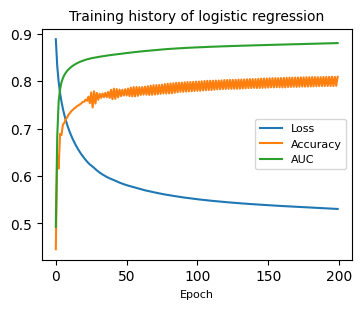

In [308]:
plt.figure(figsize=(4, 3))
plt.plot(model_history.epoch, model_history.history['loss'], label='Loss')
plt.plot(model_history.epoch, model_history.history['accuracy'], label='Accuracy')
plt.plot(model_history.epoch, model_history.history['auc_4'], label='AUC')
plt.xlabel('Epoch',fontsize = 8)
plt.title('Training history of logistic regression', fontsize = 10)
plt.legend(fontsize = 8)
plt.show()

We can see that the algorithm converges after 50 epochs approximately.

In [106]:
result = model.evaluate(test_ds)
print('Accuracy on test set {0:.2%} AUC {1:.2f}'.format(result[1], result[2]))

1/1 [==============================] - 1s 1s/step - loss: 0.5410 - accuracy: 0.7889 - auc_1: 0.8749
Accuracy on test set 78.89% AUC 0.87


#### Model evaluation

In [255]:
lr_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[1,0])
y_score_lr = lr_classifier.decision_function(X_test)
fpr_lr, tpr_lr, auc_thresholds_lr = roc_curve(y_test, y_score)

print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))
print("Recall Score:", recall_score(y_test, y_pred_lr, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_lr, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_lr, labels=[1,0]))

Accuracy Score: 0.8066442388561816
Recall Score: 0.6392801251956182
Precision Score: 0.8066290550070522
F1 Score: 0.7132701421800948


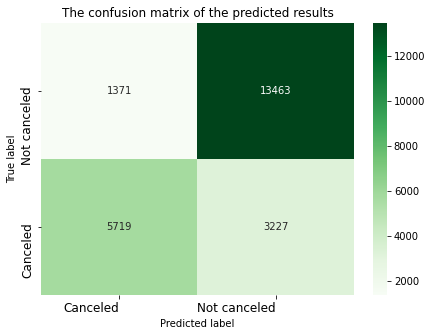

In [257]:
plot_confusion_matrix(cm_lr)

### 4.2 Baseline model 2: Decision Tree

#### Initial training

In [78]:
# Train the classifier
dt_classfier = DecisionTreeClassifier(
                criterion = 'entropy',
                max_depth = 10,
                max_features = 'log2',
                min_samples_leaf = 8,
                min_samples_split = 2).fit(X_train, y_train)

In [80]:
# Evaluate initially
y_pred_dt_ini = dt_classfier.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred_dt_ini))
print("Recall Score:", recall_score(y_test, y_pred_dt_ini, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_dt_ini, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_dt_ini, labels=[1,0]))

Accuracy Score: 0.743650126156434
Recall Score: 0.37592219986586184
Precision Score: 0.8676470588235294
F1 Score: 0.5245671502105757


#### Model improvement

We choose max depth as the hyper-parameter of the decision tree.

In [102]:
# Define the grid search space
dt_max_depth_list = range(1, 30)
dt_train_scores = []
dt_cv_scores = []

# 5-fold cross validation on training set
for d in dt_max_depth_list:
    dt_classifier = DecisionTreeClassifier(
            criterion = 'entropy',
            max_depth = d,
            max_features = 'log2',
            min_samples_leaf = 8,
            min_samples_split = 2)
    train_score = precision_score(y_train, dt_classifier.fit(X_train, y_train).predict(X_train), labels=[1,0])
    cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv = 5, scoring = 'f1')
    dt_train_scores.append(train_score)
    dt_cv_scores.append(cv_scores.mean())

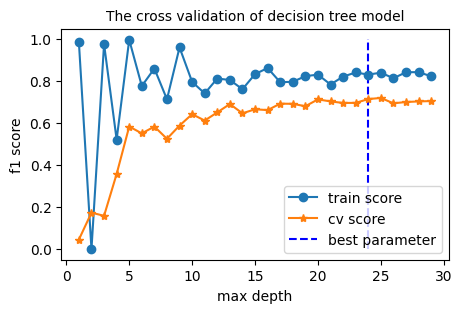

In [309]:
plt.figure(figsize=(5,3))
plt.plot(dt_max_depth_list, dt_train_scores, 'o-', label = 'train score')
plt.plot(dt_max_depth_list, dt_cv_scores, '*-', label = 'cv score')
plt.title('The cross validation of decision tree model', fontsize=10)
plt.xlabel('max depth')
plt.ylabel('f1 score')
plt.vlines(np.argmax(dt_cv_scores), 0,1, colors = 'b', linestyles = 'dashed', label = 'best parameter')
plt.legend()
plt.show()

In [120]:
print('We will choose {} as the max depth of the decision tree.'.format(np.argmax(dt_cv_scores)))

We will choose 24 as the max depth of the decision tree.


#### Model evaluation

In [175]:
# Train the classifier with the best hyper-parameter
dt_classifier_improved = DecisionTreeClassifier(
                criterion = 'entropy',
                max_depth = 24,
                max_features = 'log2',
                min_samples_leaf = 8,
                min_samples_split = 2).fit(X_train, y_train)

In [176]:
# Predict and compute several metrics
y_pred_dt = dt_classifier_improved.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=[1,0])
y_score_dt = dt_classifier_improved.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, auc_thresholds_dt = roc_curve(y_test, y_score_dt)

print("Accuracy Score:", accuracy_score(y_test, y_pred_dt))
print("Recall Score:", recall_score(y_test, y_pred_dt, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_dt, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_dt, labels=[1,0]))

Accuracy Score: 0.7846930193439865
Recall Score: 0.5562262463670914
Precision Score: 0.812275546849494
F1 Score: 0.6602972399150743


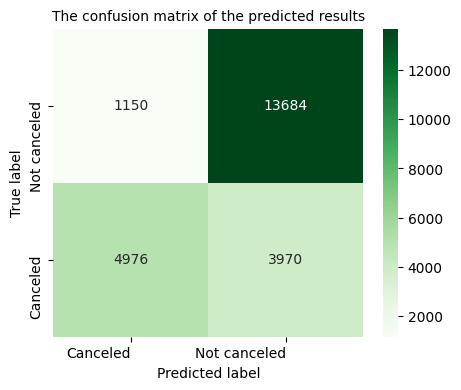

In [320]:
plot_confusion_matrix(cm_dt)

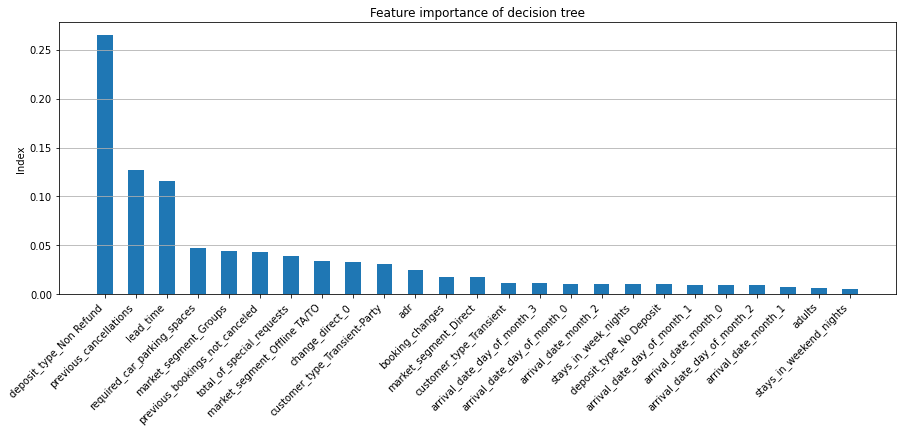

In [242]:
# Visualize the feature importance
feature_importance_dt = pd.DataFrame(dt_classifier_improved.feature_importances_, index=X_train.columns, columns=['Weight'])
feature_importance_dt = feature_importance_dt.sort_values(by = 'Weight', ascending=False)[:25]
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title('Feature importance of decision tree')
ax.tick_params(labelsize = 10)
ax.set_ylabel('Index', fontsize = 10)
ax.grid(axis = 'y')
ax.bar(feature_importance_dt.index, feature_importance_dt['Weight'], width = 0.5)
plt.xticks(np.arange(len(feature_importance_dt)),feature_importance_dt.index,rotation = 45, fontsize = 10,ha='right')
plt.tight_layout
plt.show()

### 4.3 Ensemble model 1: Random Forest

#### Initial training

In [142]:
# Train the classifier
rf_classifier = RandomForestClassifier(
                n_estimators = 100,
                criterion = 'entropy',
                class_weight = 'balanced',
                max_depth = 24,
                max_features = 'log2',
                min_samples_leaf = 8,
                min_samples_split = 2,
                bootstrap = True, 
                oob_score = True, 
                n_jobs=-1).fit(X_train, y_train)

In [143]:
# Evaluate initially
y_pred_rf_ini = rf_classifier.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred_rf_ini))
print("Recall Score:", recall_score(y_test, y_pred_rf_ini, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_rf_ini, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_rf_ini, labels=[1,0]))

Accuracy Score: 0.8211522287636669
Recall Score: 0.7208808405991505
Precision Score: 0.7859841560024375
F1 Score: 0.7520261209258935


#### Model improvement

We keep the 24 as the max depth of each decision tree in random forest. And firstly, we do hyper-parameter tuning on the number of trees.

In [321]:
# Define the grid search space
rf_num_tree_list = range(10, 160, 10)
rf_train_scores_trees = []
rf_cv_scores_trees = []

# 5-fold cross validation
for n in rf_num_tree_list:
    rf_classifier = RandomForestClassifier(
                n_estimators = n,
                criterion = 'entropy',
                class_weight = 'balanced',
                max_depth = 24,
                min_samples_leaf = 8,
                min_samples_split = 2,
                bootstrap = True, 
                oob_score = True, 
                n_jobs=-1)
    train_score = precision_score(y_train, rf_classifier.fit(X_train, y_train).predict(X_train), labels=[1,0])
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv = 5, scoring = 'f1')
    rf_train_scores_trees.append(train_score)
    rf_cv_scores_trees.append(cv_scores.mean())

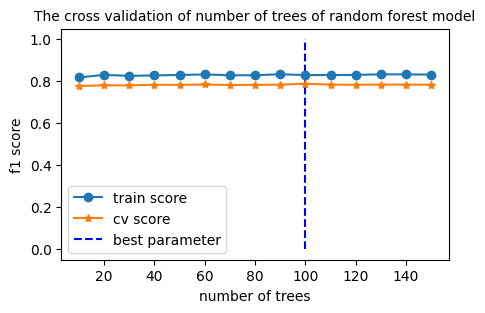

In [351]:
plt.figure(figsize = (5,3))
plt.plot(rf_num_tree_list, rf_train_scores_trees, 'o-', label = 'train score')
plt.plot(rf_num_tree_list, rf_cv_scores_trees, '*-', label = 'cv score')
plt.title('The cross validation of number of trees of random forest model', fontsize = 10)
plt.xlabel('number of trees')
plt.ylabel('f1 score')
plt.vlines(rf_num_tree_list[np.argmax(rf_cv_scores_trees)], 0,1, colors = 'b', linestyles = 'dashed', label = 'best parameter')
plt.legend()
plt.show()

We can see that the number of trees does not affect the F1 score obviously, so we choose 100 as the number of trees and do hyper-parameter tuning on another one, which is the max features.

In [144]:
# Define the grid search space
rf_max_features_list = range(1, 40, 2)
rf_train_scores = []
rf_cv_scores = []

# 5-fold cross validation
for f in rf_max_features_list:
    rf_classifier = RandomForestClassifier(
                n_estimators = 100,
                criterion = 'entropy',
                class_weight = 'balanced',
                max_depth = 24,
                max_features = f,
                min_samples_leaf = 8,
                min_samples_split = 2,
                bootstrap = True, 
                oob_score = True, 
                n_jobs=-1)
    train_score = precision_score(y_train, rf_classifier.fit(X_train, y_train).predict(X_train), labels=[1,0])
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv = 5, scoring = 'f1')
    rf_train_scores.append(train_score)
    rf_cv_scores.append(cv_scores.mean())

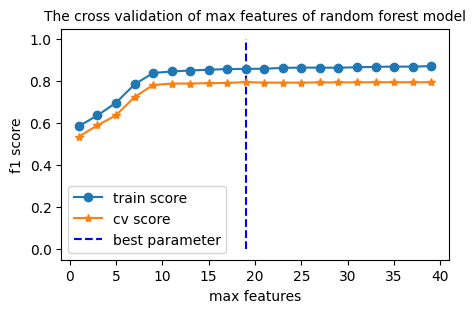

In [350]:
plt.figure(figsize = (5,3))
plt.plot(rf_max_features_list, rf_train_scores, 'o-', label = 'train score')
plt.plot(rf_max_features_list, rf_cv_scores, '*-', label = 'cv score')
plt.title('The cross validation of max features of random forest model', fontsize = 10)
plt.xlabel('max features')
plt.ylabel('f1 score')
plt.vlines(rf_max_features_list[np.argmax(rf_cv_scores)], 0,1, colors = 'b', linestyles = 'dashed', label = 'best parameter')
plt.legend()
plt.show()

In [339]:
print('We will choose {} as the max features of the random forest.'.format(rf_max_features_list[np.argmax(rf_cv_scores)]))

We will choose 18 as the max features of the random forest.


#### Model evaluation

In [165]:
# Train the classifier with the tuned hyper-parameter
rf_classifier_improved = RandomForestClassifier(
                n_estimators = 100,
                criterion = 'entropy',
                class_weight = 'balanced',
                max_depth = 24,
                max_features = 18,
                min_samples_leaf = 8,
                min_samples_split = 2,
                bootstrap = True, 
                oob_score = True, 
                n_jobs=-1).fit(X_train, y_train)

In [168]:
# Predict and compute several metrics
y_pred_rf = rf_classifier_improved.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[1,0])
y_score_rf = rf_classifier_improved.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, auc_thresholds_rf = roc_curve(y_test, y_score_rf)

print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Recall Score:", recall_score(y_test, y_pred_rf, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_rf, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_rf, labels=[1,0]))

Accuracy Score: 0.8255256518082422
Recall Score: 0.7436843281913704
Precision Score: 0.781878011517217
F1 Score: 0.7623030650243483


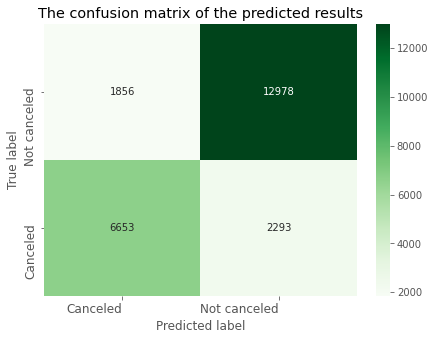

In [261]:
plot_confusion_matrix(cm_rf)

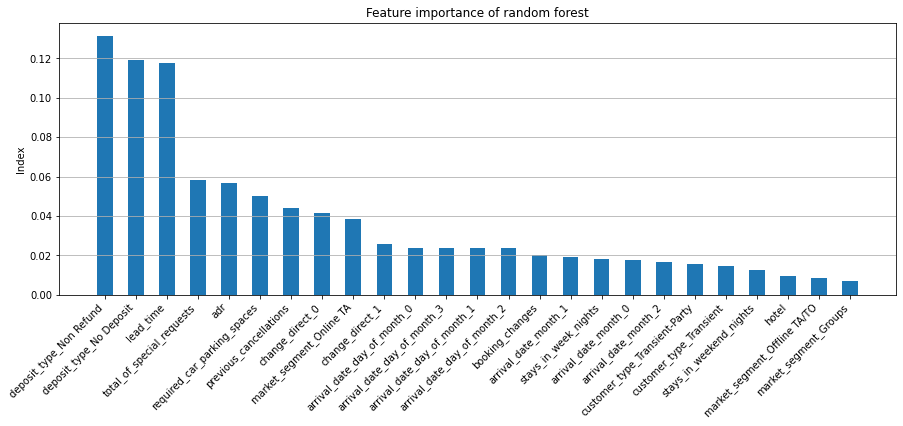

In [248]:
# Visualize the feature importance of random forest
feature_importance_rf = pd.DataFrame(rf_classifier_improved.feature_importances_, index=X_train.columns, columns=['Weight'])
feature_importance_rf = feature_importance_rf.sort_values(by = 'Weight', ascending=False)[:25]
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title('Feature importance of random forest')
ax.tick_params(labelsize = 10)
ax.set_ylabel('Index', fontsize = 10)
ax.grid(axis = 'y')
ax.bar(feature_importance_rf.index, feature_importance_rf['Weight'], width = 0.5)
plt.xticks(np.arange(len(feature_importance_rf)),feature_importance_rf.index,rotation = 45, fontsize = 10,ha='right')
plt.tight_layout
plt.show()

### 4.4 Model - AdaBoost

#### Initial training

In [197]:
# Train the classifier
ab_classifier = AdaBoostClassifier(
                n_estimators = 100,
                learning_rate = 2,
                algorithm = 'SAMME.R').fit(X_train, y_train)

In [198]:
# Evaluate initially
y_pred_ab_ini = ab_classifier.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred_ab_ini))
print("Recall Score:", recall_score(y_test, y_pred_ab_ini, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_ab_ini, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_ab_ini, labels=[1,0]))

Accuracy Score: 0.7472666105971405
Recall Score: 0.3302034428794992
Precision Score: 0.993943472409152
F1 Score: 0.4957207585165296


#### Model improvement

We choose learning rate as the hyper-parameter.

In [190]:
# Define the hyper-parameter space
ab_learning_rate_list = np.arange(0.2, 5.2, 0.2)
ab_train_scores = []
ab_cv_scores = []

# 5-fold cross validation
for r in ab_learning_rate_list:
    ab_classifier = AdaBoostClassifier(
                n_estimators = 100,
                learning_rate = r,
                algorithm = 'SAMME.R')
    train_score = precision_score(y_train, ab_classifier.fit(X_train, y_train).predict(X_train), labels=[1,0])
    cv_scores = cross_val_score(ab_classifier, X_train, y_train, cv = 5, scoring = 'f1')
    ab_train_scores.append(train_score)
    ab_cv_scores.append(cv_scores.mean())

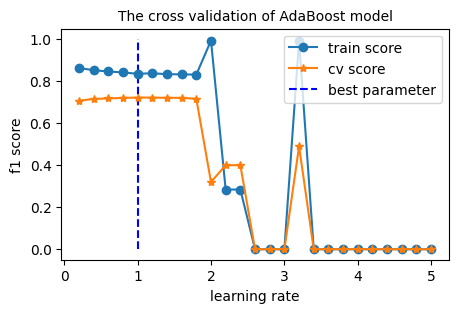

In [352]:
plt.figure(figsize = (5,3))
plt.plot(ab_learning_rate_list, ab_train_scores, 'o-', label = 'train score')
plt.plot(ab_learning_rate_list, ab_cv_scores, '*-', label = 'cv score')
plt.title('The cross validation of AdaBoost model',fontsize=10)
plt.xlabel('learning rate')
plt.ylabel('f1 score')
plt.vlines(ab_learning_rate_list[np.argmax(ab_cv_scores)], 0,1, colors = 'b', linestyles = 'dashed', label = 'best parameter')
plt.legend()
plt.show()

In [206]:
print('We will choose {} as the learning rate of the AdaBoost.'.format(ab_learning_rate_list[np.argmax(ab_cv_scores)]))

We will choose 1.0 as the learning rate of the AdaBoost.


#### Model evaluation

In [208]:
# Train the classifier with the tuned hyper-parameter
ab_classifier_improved = AdaBoostClassifier(
                n_estimators = 100,
                learning_rate = 1,
                algorithm = 'SAMME.R').fit(X_train, y_train)

In [209]:
# Predict and compute several metrics
y_pred_ab = ab_classifier_improved.predict(X_test)
cm_ab = confusion_matrix(y_test, y_pred_ab, labels=[1,0])
y_score_ab = ab_classifier_improved.predict_proba(X_test)[:,1]
fpr_ab, tpr_ab, auc_thresholds_ab = roc_curve(y_test, y_score_ab)

print("Accuracy Score:", accuracy_score(y_test, y_pred_ab))
print("Recall Score:", recall_score(y_test, y_pred_ab, labels=[1,0]))
print("Precision Score:", precision_score(y_test, y_pred_ab, labels=[1,0]))
print("F1 Score:", f1_score(y_test, y_pred_ab, labels=[1,0]))

Accuracy Score: 0.8121530698065601
Recall Score: 0.6604068857589984
Precision Score: 0.8052337467629821
F1 Score: 0.7256648037830865


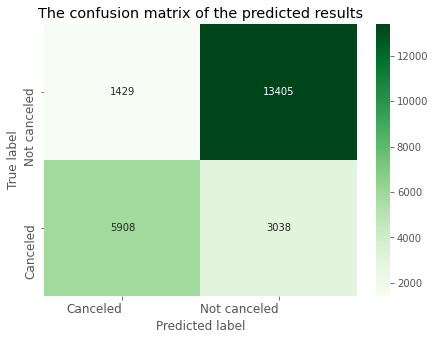

In [262]:
plot_confusion_matrix(cm_ab)

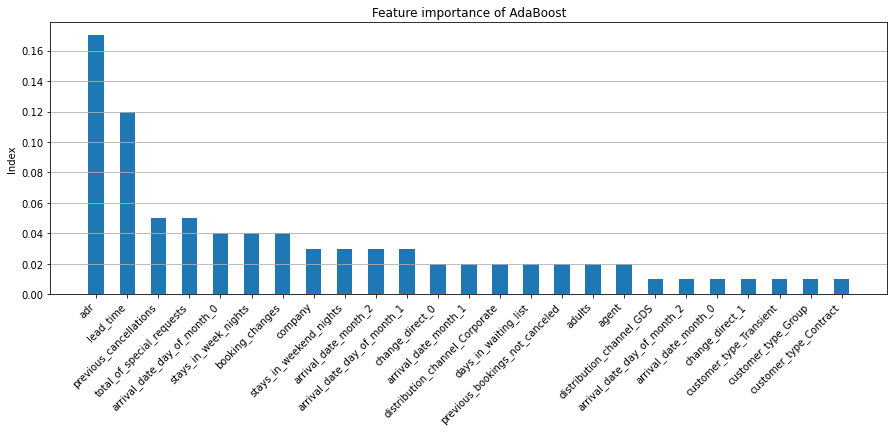

In [251]:
# Visulaize the feature importance of AdaBoost
feature_importance_ab = pd.DataFrame(ab_classifier_improved.feature_importances_, index=X_train.columns, columns=['Weight'])
feature_importance_ab = feature_importance_ab.sort_values(by = 'Weight', ascending=False)[:25]
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title('Feature importance of AdaBoost')
ax.tick_params(labelsize = 10)
ax.set_ylabel('Index', fontsize = 10)
ax.grid(axis = 'y')
ax.bar(feature_importance_ab.index, feature_importance_ab['Weight'], width = 0.5)
plt.xticks(np.arange(len(feature_importance_ab)),feature_importance_ab.index,rotation = 45, fontsize = 10,ha='right')
plt.tight_layout
plt.savefig('fi_ab.jpg', dpi=600, bbox_inches = 'tight')
plt.show()

### Model conclusion

We plot the ROC curves and calculate the area under ROC curve of four classifiers respectively.

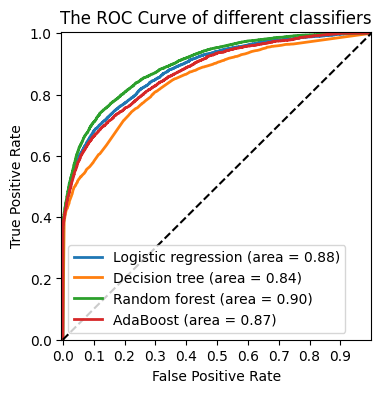

In [354]:
plt.figure(figsize=(4,4))
plt.title('The ROC Curve of different classifiers')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label = 'Logistic regression (area = {:.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.plot(fpr_dt, tpr_dt, linewidth=2, label = 'Decision tree (area = {:.2f})'.format(auc(fpr_dt, tpr_dt)))
plt.plot(fpr_rf, tpr_rf, linewidth=2, label = 'Random forest (area = {:.2f})'.format(auc(fpr_rf, tpr_rf)))
plt.plot(fpr_ab, tpr_ab, linewidth=2, label = 'AdaBoost (area = {:.2f})'.format(auc(fpr_ab, tpr_ab)))
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.1))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The detailed comparison among classifiers is described in the report.

---